# Interpretability

Sul fold migliore vado a fare forward pass e calcolarmi i gradienti, i positional embedding, correlazioni, curvatura e path degli input che danno quei risultati

Pensiero random (potrebbe essere carino per la tesi e quasi d’obbligo per il paper), lo lascerei comunque come ultimo step se abbiamo tempo: riusciamo sulla fold che va meglio, del dataset che va meglio per il nostro modello tenere traccia in validation di quali sono le coppie di feature (in modo da rintracciare la coppia rad-histo) che portano gradienti maggiori e minori e salvare le rispettive correlazioni (e calcolare il rischio)? Questo significa rintracciare le coppie la cui correlazione ha un’importanza o meno nel calcolo del rischio.
Quello che sarebbe interessante far vedere sono gli estremi opposti su due coppie di rad histo con:
Alta correlazione, alto gradiente, alto risk score, basso survival, alto grado di tumore: sulla radiologia calcolare tipo regolarità della forma (che ci i aspetta bassa, usando la segmentazione), grandezza tumore (che ci si aspetta alta, usando la segmentazione) e sulla histo il numero di cellule epiteliali cancerogene (che ci si aspetta alta, cosa che si può fare con una rete pretrainata) 
Alta correlazione, basso gradiente, basso risk score, alto survival, basso grado di tumore: sulla radiologia calcolare tipo regolarità della forma (che ci i aspetta alta), grandezza tumore (che ci si aspetta bassa, usando la segmentazione) e sulla histo il numero di cellule epiteliali cancerogene (che ci si aspetta bassa, cosa che si può fare con una rete pretrainata) 
Se tu ti occupi di tracciare i gradienti/correlazioni/file (non dovrebbe essere troppo complesso, basta salvarsi le combinazioni di risultati su un file), io mi occuperei di tutto il resto

### Define Functions for interpretability analysis

In [1]:
import os
import random
from itertools import product
#from pathlib import Path

#import cv2
import h5py
import numpy as np
import pandas as pd
import torch
#import torchstain
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
#from torchvision import transforms
from tqdm import tqdm


class   MultimodalCTWSIDatasetSurv(Dataset):
    """
    Dataset class for paired CT and WSI data, handling missing modalities
        at both dataset and sampling level
    """

    def __init__(
        self,
        fold: int,
        split: str,  # either "train" or "test"
        ct_path: str,
        wsi_path: str,
        labels_splits_path: str,
        missing_modality_prob: float = 0.0,  # Additional random masking probability
        missing_modality: str = "both",
        require_both_modalities: bool = False,  # Whether to only include patients
        # with both modalities
        pairing_mode: str = None,  # 'all_combinations, 'one_to_one', 'fixed_count'
        pairs_per_patient: int = None,  # For fixed_count_mode
        allow_repeats: bool = False,  # For fixed_count mode
    ):
        super().__init__()
        # assert split in ["train", "val", "overfit", "all"]
        assert split in ["train", "test"]
        assert pairing_mode in ["all_combinations", "one_to_one", "fixed_count"]
        assert 0 <= missing_modality_prob <= 1
        assert missing_modality in ["ct", "wsi", "both"]
        self.missing_modality = missing_modality
        self.fold = fold
        self.split = split
        self.ct_path = ct_path
        self.wsi_path = wsi_path
        self.missing_modality_prob = missing_modality_prob
        self.require_both_modalities = require_both_modalities
        self.labels_splits_path = labels_splits_path
        self.pairing_mode = (
            pairing_mode  # 'all_combinations', 'one_to_one', or 'fixed_count'
        )
        self.pairs_per_patient = pairs_per_patient  # For fixed_count mode
        self.allow_repeats = allow_repeats  # For fixed_count mode
        labels_splits = pd.read_csv(labels_splits_path, sep="\t")
        labels_splits = labels_splits[labels_splits[f"fold_{self.fold}"] == self.split]
        self.labels_splits = labels_splits[
            ["case_id", "OS_days", "OS_event"]
        ].drop_duplicates("case_id")

        # Initialize data structures
        # Will store CT and WSI paths per patient
        self.patient_data = {}
        # Will store all valid combinations
        self.samples = []
        self.modality_stats = {"ct_only": 0, "wsi_only": 0, "both": 0}

        # Load split file
        self._load_split()

    def _get_max_pairs_for_patient(self, ct_scans, wsi_folders, allow_repeats):
        """
        Calculate maximum possible pairs for a patient based on available data and pairing mode.

        Args:
            ct_scans (list): List of CT scan files
            wsi_folders (list): List of WSI folder names
            allow_repeats (bool): If True, return all possible combinations count
                                If False, return maximum unique pairs count

        Returns:
            int: Maximum number of possible pairs
        """
        if not ct_scans or not wsi_folders:
            return 0

        if allow_repeats:
            return len(ct_scans) * len(wsi_folders)
        else:  # one-to-one
            return min(len(ct_scans), len(wsi_folders))

    def _get_fixed_pairs(self, ct_scans, wsi_folders, n_pairs, allow_repeats=True):
        """
        Generate fixed number of pairs between CT scans and WSI folders.

        Args:
            ct_scans (list): List of CT scan files
            wsi_folders (list): List of WSI folder names
            n_pairs (int): Number of pairs to generate
            allow_repeats (bool): If True, allows repeating elements to reach n_pairs
                                If False, limits pairs to minimum unique combinations

        Returns:
            list: List of (ct_scan, wsi_folder) pairs
        """
        max_unique_pairs = min(len(ct_scans), len(wsi_folders))

        if not allow_repeats:
            n_pairs = min(n_pairs, max_unique_pairs)

        # Generate initial unique pairs
        shuffled_ct = ct_scans.copy()
        shuffled_wsi = wsi_folders.copy()
        random.shuffle(shuffled_ct)
        random.shuffle(shuffled_wsi)

        pairs = list(
            zip(shuffled_ct[:max_unique_pairs], shuffled_wsi[:max_unique_pairs])
        )

        if n_pairs <= len(pairs):
            # Downsample if needed
            random.shuffle(pairs)
            return pairs[:n_pairs]

        if not allow_repeats:
            return pairs

        # Need to generate additional pairs with repeats
        while len(pairs) < n_pairs:
            ct_scan = random.choice(ct_scans)
            wsi_folder = random.choice(wsi_folders)
            pairs.append((ct_scan, wsi_folder))

        return pairs

    def _load_split(self):
        """Load and organize all CT and WSI data for the given split

        Supports different pairing modes:
        - 'all_combinations': Creates all possible CT-WSI pairs
        - 'one_to_one': Creates random 1:1 pairs
        - 'fixed_count': Creates fixed number of pairs per patient
        """

        # First pass: count maximum possible pairs per patient
        max_pairs_possible = float("inf")
        if self.pairing_mode == "fixed_count":
            for patient_id in self.labels_splits["case_id"].values:

                ct_path = os.path.join(self.ct_path, patient_id)
                ct_features = []
                if os.path.exists(ct_path):
                    ct_features = [f for f in os.listdir(ct_path)]

                wsi_path = os.path.join(self.wsi_path)
                wsi_features = [
                    f
                    for f in os.listdir(wsi_path)
                    if patient_id in f and os.path.isdir(os.path.join(wsi_path, f))
                ]

                patient_max_pairs = self._get_max_pairs_for_patient(
                    ct_features, wsi_features, self.allow_repeats
                )

                if patient_max_pairs > 0:  # Only update if patient has both modalities

                    max_pairs_possible = min(max_pairs_possible, patient_max_pairs)

        # Use provided pairs_per_patient or calculated maximum
        n_pairs = (
            self.pairs_per_patient
            if self.pairs_per_patient is not None
            else max_pairs_possible
        )

        # Main loading loop
        for row in self.labels_splits["case_id"].values:
            patient_id = row.strip()
            # Find all CT scans for this patient
            ct_path = os.path.join(self.ct_path, patient_id)
            ct_features = []
            if os.path.exists(ct_path):
                ct_features = [f for f in os.listdir(ct_path)]

            # Find all WSI .h5 files for this patient
            wsi_path = self.wsi_path
            wsi_features = [f for f in os.listdir(wsi_path) if patient_id in f]

            # Skip patient if we require both modalities and they don't have them
            if self.require_both_modalities and (not ct_features or not wsi_features):
                continue

            # Store available data for this patient
            self.patient_data[patient_id] = {
                "ct_features": ct_features,
                "wsi_features": wsi_features,
            }

            # Update modality statistics
            if ct_features and wsi_features:
                self.modality_stats["both"] += 1
            elif ct_features:
                self.modality_stats["ct_only"] += 1
            else:
                self.modality_stats["wsi_only"] += 1

            cnt = 0
            # Generate samples based on available data and pairing mode
            if ct_features and wsi_features:
                if self.pairing_mode == "fixed_count":
                    # Generate fixed number of pairs
                    pairs = self._get_fixed_pairs(
                        ct_features, wsi_features, n_pairs, self.allow_repeats
                    )

                    for ct_feature, wsi_feature in pairs:
                        cnt += 1
                        self.samples.append(
                            {
                                "patient_id": patient_id,
                                "ct_path": os.path.join(
                                    self.ct_path, patient_id, ct_feature
                                ),
                                "wsi_folder": os.path.join(self.wsi_path, wsi_feature),
                                "base_modality_mask": [1, 1],
                            }
                        )

                elif self.pairing_mode == "one_to_one":
                    # Original one_to_one logic
                    num_pairs = min(len(ct_features), len(wsi_features))
                    shuffled_ct = ct_features.copy()
                    shuffled_wsi = wsi_features.copy()
                    random.shuffle(shuffled_ct)
                    random.shuffle(shuffled_wsi)

                    for ct_feature, wsi_feature in zip(
                        shuffled_ct[:num_pairs], shuffled_wsi[:num_pairs]
                    ):
                        cnt += 1
                        self.samples.append(
                            {
                                "patient_id": patient_id,
                                "ct_path": os.path.join(
                                    self.ct_path, patient_id, ct_feature
                                ),
                                "wsi_feature": os.path.join(self.wsi_path, wsi_feature),
                                "base_modality_mask": [1, 1],
                            }
                        )

                else:  # 'all_combinations' mode
                    for ct_feature, wsi_feature in product(ct_features, wsi_features):
                        cnt += 1
                        self.samples.append(
                            {
                                "patient_id": patient_id,
                                "ct_path": os.path.join(
                                    self.ct_path, patient_id, ct_feature
                                ),
                                "wsi_feature": os.path.join(self.wsi_path, wsi_feature),
                                "base_modality_mask": [1, 1],
                            }
                        )

            elif ct_features:
                for ct_feature in ct_features:
                    cnt += 1
                    self.samples.append(
                        {
                            "patient_id": patient_id,
                            "ct_path": os.path.join(
                                self.ct_path, patient_id, ct_feature
                            ),
                            "wsi_feature": None,
                            "base_modality_mask": [1, 0],
                        }
                    )

            elif wsi_features:
                for wsi_feature in wsi_features:
                    cnt += 1
                    self.samples.append(
                        {
                            "patient_id": patient_id,
                            "ct_path": None,
                            "wsi_feature": os.path.join(self.wsi_path, wsi_feature),
                            "base_modality_mask": [0, 1],
                        }
                    )

    def _load_ct_feature(self, ct_path):
        """Load and standardize CT feature"""
        if ct_path.endswith(".pt"):
            volume = np.array(torch.load(ct_path, weights_only=True))
        elif ct_path.endswith(".npy"):
            volume = np.load(ct_path)
        return volume

    def _load_wsi_feature(self, wsi_path):
        """Load WSI feature"""
        feature = None
        with h5py.File(wsi_path, "r") as f:
            feature = np.array(f["features"][:])

        return feature

    def _get_empty_ct_feature(self):
        """Return empty CT feature of correct shape"""
        return np.zeros((66, 1024))

    def _get_empty_wsi_feature(self):
        """Return empty WSI feature of correct shape"""
        return np.zeros((768,))

    def __getitem__(self, index):
        """
        Returns:
            dict: {
                'patient_id': str,
                'ct_feature': numpy array or zeros if missing,
                'wsi_feature': tensor or zeros if missing,
                'label': int,
                'modality_mask': tensor indicating present modalities [CT, WSI],
                'base_modality_mask': tensor indicating modalities available in dataset
            }
        """

        sample = self.samples[index]
        patient_id = sample["patient_id"]
        base_mask = sample["base_modality_mask"]
        ct_path = sample["ct_path"]
        wsi_path = sample["wsi_feature"]
        if wsi_path is None: wsi_path = ""
        if ct_path is None: ct_path = ""
        # Apply additional random masking only to available modalities
        final_mask = base_mask.copy()
        if self.missing_modality_prob > 0:
            if self.missing_modality == "both":
                for i in range(2):
                    if (
                        base_mask[i] == 1
                        and random.random() < self.missing_modality_prob
                    ):
                        final_mask[i] = 0
            elif self.missing_modality == "ct":
                if base_mask[0] == 1 and random.random() < self.missing_modality_prob:
                    final_mask[0] = 0
            elif self.missing_modality == "wsi":
                if base_mask[1] == 1 and random.random() < self.missing_modality_prob:
                    final_mask[1] = 0

            # Ensure at least one modality remains if it was originally available
            if sum(final_mask) == 0 and sum(base_mask) > 0:
                # Randomly choose one of the originally available modalities
                available_indices = [i for i in range(2) if base_mask[i] == 1]
                chosen_idx = random.choice(available_indices)
                final_mask[chosen_idx] = 1

        # Load features based on final mask
        ct_feature = (
            self._load_ct_feature(sample["ct_path"])
            if final_mask[0] and sample["ct_path"]
            else self._get_empty_ct_feature()
        )

        wsi_feature = (
            self._load_wsi_feature(sample["wsi_feature"])
            if final_mask[1] and sample["wsi_feature"]
            else self._get_empty_wsi_feature()
        )

        return {
            "patient_id": patient_id,
            "ct_feature": torch.from_numpy(ct_feature).float(),
            "wsi_feature": torch.from_numpy(wsi_feature).float(),
            "survtime": torch.tensor(
                self.labels_splits[self.labels_splits["case_id"] == patient_id][
                    "OS_days"
                ].iloc[0],
                dtype=torch.long,
            ),
            "censor": ~torch.tensor(
                self.labels_splits[self.labels_splits["case_id"] == patient_id][
                    "OS_event"
                ].iloc[0],
                dtype=torch.bool,
            ),
            "modality_mask": torch.tensor(final_mask, dtype=torch.float32),
            "base_modality_mask": torch.tensor(base_mask, dtype=torch.float32),
            "ct_path": ct_path,
            "wsi_path": wsi_path
        }

    def __len__(self):
        return len(self.samples)

    def stats(self):
        """Return dataset statistics"""
        return {
            "total_samples": len(self.samples),
            "total_patients": len(self.patient_data),
            "modality_availability": self.modality_stats,
            "missing_modality_prob": self.missing_modality_prob,
        }

    @staticmethod
    def move_batch_to_device(batch, device):
        """Move all elements of the batch to device"""
        batch["ct_feature"] = batch["ct_feature"].to(device)
        batch["wsi_feature"] = batch["wsi_feature"].to(device)
        batch["survtime"] = batch["survtime"].to(device)
        batch["censor"] = batch["censor"].to(device)
        batch["modality_mask"] = batch["modality_mask"].to(device)
        batch["ct_path"] = batch["ct_path"].to(device)
        batch["wsi_path"] = batch["wsi_path"].to(device)


In [6]:
import os
import torch
import csv
import numpy as np
from torch.utils.data import DataLoader

#from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
from torch.nn.modules.loss import _WeightedLoss


class CoxLoss(_WeightedLoss):
    def forward(self, hazard_pred: torch.Tensor, survtime: torch.Tensor, censor: torch.Tensor):
        censor = censor.float()
        n = len(survtime)
        # risk‑set matrix
        R_mat = survtime.reshape((1, n)) >= survtime.reshape((n, 1))
        theta = hazard_pred.reshape(-1)
        exp_theta = torch.exp(theta)
        # negative log‑partial likelihood
        loss = -torch.mean((theta - torch.log(torch.sum(exp_theta * R_mat, dim=1))) * censor)
        return loss


def compute_grad_and_curvature(fused_features, hazard, survtime, censor):
    hazard = hazard.view(-1)
    loss = CoxLoss()(hazard, survtime, censor)
    # first derivative
    grad_f = torch.autograd.grad(loss, fused_features, create_graph=True)[0]
    grad_norm = grad_f.flatten(1).norm(p=2, dim=1)

    # Hutchinson estimator for Hessian diagonal
    random_vec = grad_f.detach().clone().sign()
    grad_dot_random = torch.sum(grad_f * random_vec)
    hvp = torch.autograd.grad(grad_dot_random, fused_features, retain_graph=False)[0]
    curvature = torch.sum(hvp * random_vec, dim=list(range(1, hvp.ndim)))

    return grad_norm.detach().cpu().numpy(), curvature.detach().cpu().numpy()


def evaluate_and_log(folds_dir, ct_path, wsi_path, test_path, output_dir, batch_size=16, n_folds=5):
    os.makedirs(output_dir, exist_ok=True)

    for fold in range(n_folds):
        print(f"\n=== Fold {fold} ===")
        model = MADPENetNoBackbonesSurv(
            rad_input_dim=1024, histo_input_dim=768,
            inter_dim=256, token_dim=256, dim_hider=256
        )
        model.eval()

        # Load checkpoint
        fold_dir = os.path.join(folds_dir, f"fold_{fold}")
        model_subdir = next(d for d in os.listdir(fold_dir)
                            if os.path.isdir(os.path.join(fold_dir, d)))
        model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_subdir))
                          if f.endswith("mixed_missing.pth"))
        checkpoint = torch.load(
            os.path.join(fold_dir, model_subdir, model_file), map_location="cpu"
        )
        model.load_state_dict(checkpoint["model_state_dict"])

        dataset = MultimodalCTWSIDatasetSurv(
            fold=fold,
            split="test",
            ct_path=ct_path,
            wsi_path=wsi_path,
            labels_splits_path=test_path,
            missing_modality_prob=0.0,
            require_both_modalities=True,
            pairing_mode="one_to_one",
            allow_repeats=True,
            pairs_per_patient=None,
            missing_modality="wsi"
        )

        loader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=0)

        # CSV Logger
        log_file = os.path.join(output_dir, f"fold_{fold}_log.csv")
        fold_tensor_dir = os.path.join(output_dir, f"fold_{fold}")
        os.makedirs(fold_tensor_dir, exist_ok=True)

        with open(log_file, "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                "patient_id", "ct_path", "wsi_path",
                "ct_available", "wsi_available",
                "hazard_score", "survtime", "censor",
                "grad_norm", "curvature",
                "fused_path", "pe_path", "hazard_tensor_path"
            ])

            sample_counter = 0
            for batch in loader:
                # ensure floats
                for k, v in batch.items():
                    if isinstance(v, torch.Tensor):
                        batch[k] = v.float()

                with torch.enable_grad():
                    for v in batch.values():
                        if isinstance(v, torch.Tensor):
                            v.requires_grad = True

                    outputs = model(
                        batch["ct_feature"],
                        batch["wsi_feature"],
                        modality_flag=batch["modality_mask"],
                        output_layers=["hazard", "fused_features", "positional_embeddings"]
                    )
                    hazard = outputs["hazard"].squeeze(1)  # [B]
                    fused_features = outputs["fused_features"]    # [B, D]
                    pos_emb = outputs["positional_embeddings"]    # [B, D]

                    grad_norms, curvatures = compute_grad_and_curvature(
                        fused_features, hazard,
                        batch["survtime"], batch["censor"]
                    )

                # save per-sample
                B = hazard.size(0)
                for j in range(B):
                    sample_id = f"sample_{sample_counter:06d}"
                    fused_path = os.path.join(fold_tensor_dir, f"{sample_id}_fused.npy")
                    pe_path = os.path.join(fold_tensor_dir, f"{sample_id}_pe.npy")
                    hazard_path = os.path.join(fold_tensor_dir, f"{sample_id}_hazard.npy")

                    np.save(fused_path, fused_features[j].detach().cpu().numpy())
                    np.save(pe_path, pos_emb[j].detach().cpu().numpy())
                    np.save(hazard_path, hazard[j].detach().cpu().numpy())

                    ct_flag = int(batch["modality_mask"][j, 0].item())
                    wsi_flag = int(batch["modality_mask"][j, 1].item())
                    if batch["censor"][j].item()==0: continue
                    writer.writerow([
                        batch["patient_id"][j],
                        batch["ct_path"][j],
                        batch["wsi_path"][j],
                        ct_flag, wsi_flag,
                        hazard[j].item(),
                        batch["survtime"][j].item(),
                        batch["censor"][j].item(),
                        grad_norms[j], curvatures[j],
                        fused_path, pe_path, hazard_path
                    ])

                    sample_counter += 1
                    

import pandas as pd
import os
def find_topk_gradient_extremes(
    csv_path: str,
    k: int = 10,
    output_dir: str = None,
):
    """
    Finds top-k highest and lowest |gradient norm| samples from a CSV log.

    Args:
        csv_path (str): Path to fold_X_log.csv generated during eval.
        k (int): Number of top and bottom samples to retrieve.
        output_dir (str): Optional folder to save CSVs. If None, only prints results.
    """
    df = pd.read_csv(csv_path)

    if "grad_norm" not in df.columns:
        raise ValueError("The CSV does not contain 'grad_norm' column.")

    # Compute absolute gradient norms
    df["abs_grad_norm"] = df["grad_norm"].abs()

    # Sort by absolute gradient norm
    df_sorted = df.sort_values(by="abs_grad_norm", ascending=True)

    topk_low = df_sorted.head(k).copy()
    topk_high = df_sorted.tail(k).copy()[::-1]  # High to low

    print("\n🔹 Top-k LOW |Gradient Norm| Samples:")
    print(topk_low[["patient_id", "grad_norm", "abs_grad_norm", "ct_available", "wsi_available"]])

    print("\n🔸 Top-k HIGH |Gradient Norm| Samples:")
    print(topk_high[["patient_id", "grad_norm", "abs_grad_norm", "ct_available", "wsi_available"]])

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        low_path = os.path.join(output_dir, "topk_low_gradient.csv")
        high_path = os.path.join(output_dir, "topk_high_gradient.csv")
        topk_low.to_csv(low_path, index=False)
        topk_high.to_csv(high_path, index=False)
        print(f"\n📁 Saved to:\n  {low_path}\n  {high_path}")

    return topk_low, topk_high


#if __name__ == "__main__":
#    # Example usage
#    for i in range(4):
#        csv_input = f"./interpretability/interpretability_UCEC_mixed50/fold_{i}_log.csv"
#        find_topk_gradient_extremes(
#            csv_path=csv_input,
#            k=15,
#            output_dir=f"./interpretability/interpretability_UCEC_mixed50/fold_{i}_topk"
#        )


## SET GLOBAL SEED

In [2]:
import torch
import random
import numpy as np
SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

## CPTAC-PDA train-mixed 50%

In [16]:
folds_dir = "./models/ckpts/CPTACPDA_trainmixed50_multival_Titan_MedImSight_redone"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"
ct_path = "../MedImageInsights/embeddings_output_cptacpda_93"
wsi_path = "../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan"
output_dir = "./interpretability/interpretability_pda_mixed50"
evaluate_and_log(folds_dir,ct_path,wsi_path,test_path,output_dir,batch_size=16)
for i in range(5):
    csv_input = f"./interpretability/interpretability_pda_mixed50/fold_{i}_log.csv"
    find_topk_gradient_extremes(
        csv_path=csv_input,
        k=10,
        output_dir=f"./interpretability/interpretability_pda_mixed50/fold_{i}_topk"
        )


=== Fold 0 ===

=== Fold 1 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You a


=== Fold 2 ===

=== Fold 3 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You a


=== Fold 4 ===

🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
1  C3L-04479   0.015239       0.015239             1              1
0  C3L-04479   0.018554       0.018554             1              1

🔸 Top-k HIGH |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
0  C3L-04479   0.018554       0.018554             1              1
1  C3L-04479   0.015239       0.015239             1              1

📁 Saved to:
  ./interpretability/interpretability_pda_mixed50/fold_0_topk/topk_low_gradient.csv
  ./interpretability/interpretability_pda_mixed50/fold_0_topk/topk_high_gradient.csv

🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
2  C3N-02010   0.000000       0.000000             1              1
3  C3N-02010   0.000000       0.000000             1              1
0  C3L-03356   0.011778       0.011778             1              1
1  C3N-

/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


## CPTAC-PDA train-mixed 30%

In [17]:
folds_dir = "./models/ckpts/CPTACPDA_trainmixed30_multival_Titan_MedImSight"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"
ct_path = "../MedImageInsights/embeddings_output_cptacpda_93"
wsi_path = "../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan"
output_dir = "./interpretability/interpretability_PDA_mixed30"
evaluate_and_log(folds_dir,ct_path,wsi_path,test_path,output_dir,batch_size=16)
# Example usage
for i in range(5):
    csv_input = f"./interpretability/interpretability_PDA_mixed30/fold_{i}_log.csv"
    find_topk_gradient_extremes(
        csv_path=csv_input,
        k=15,
        output_dir=f"./interpretability/interpretability_PDA_mixed30/fold_{i}_topk"
    )



=== Fold 0 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 1 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 2 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 3 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 4 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
0  C3L-04479   0.000053       0.000053             1              1
1  C3L-04479   0.137801       0.137801             1              1

🔸 Top-k HIGH |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
1  C3L-04479   0.137801       0.137801             1              1
0  C3L-04479   0.000053       0.000053             1              1

📁 Saved to:
  ./interpretability/interpretability_PDA_mixed30/fold_0_topk/topk_low_gradient.csv
  ./interpretability/interpretability_PDA_mixed30/fold_0_topk/topk_high_gradient.csv

🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
1  C3N-01012   0.002529       0.002529             1              1
2  C3N-02010   0.009107       0.009107             1              1
3  C3N-02010   0.009224       0.009224             1              1
0  C3L-03356   0.011109

## CPTAC-PDA Mixed 15%

In [18]:

folds_dir = "./models/ckpts/CPTACPDA_trainmixed15_multival_Titan_MedImSight"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"
ct_path = "../MedImageInsights/embeddings_output_cptacpda_93"
wsi_path = "../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan"
output_dir = "./interpretability/interpretability_PDA_mixed15"
evaluate_and_log(folds_dir,ct_path,wsi_path,test_path,output_dir,batch_size=16)
for i in range(5):
    csv_input = f"./interpretability/interpretability_PDA_mixed15/fold_{i}_log.csv"
    find_topk_gradient_extremes(
        csv_path=csv_input,
        k=15,
        output_dir=f"./interpretability/interpretability_PDA_mixed15/fold_{i}_topk"
    )



=== Fold 0 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 1 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 2 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 3 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 4 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
1  C3L-04479   0.002971       0.002971             1              1
0  C3L-04479   0.048582       0.048582             1              1

🔸 Top-k HIGH |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
0  C3L-04479   0.048582       0.048582             1              1
1  C3L-04479   0.002971       0.002971             1              1

📁 Saved to:
  ./interpretability/interpretability_PDA_mixed15/fold_0_topk/topk_low_gradient.csv
  ./interpretability/interpretability_PDA_mixed15/fold_0_topk/topk_high_gradient.csv

🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
0  C3L-03356        0.0            0.0             1              1
1  C3N-01012        0.0            0.0             1              1
2  C3N-02010        0.0            0.0             1              1
3  C3N-02010        0.0

## CPTAC PDA mixed 5%

In [19]:

folds_dir = "./models/ckpts/CPTACPDA_trainmixed5_multival_Titan_MedImSight"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"
ct_path = "../MedImageInsights/embeddings_output_cptacpda_93"
wsi_path = "../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan"
output_dir = "./interpretability/interpretability_PDA_mixed5"

evaluate_and_log(folds_dir,ct_path,wsi_path,test_path,output_dir,batch_size=16)
for i in range(5):
    csv_input = f"./interpretability/interpretability_PDA_mixed5/fold_{i}_log.csv"
    find_topk_gradient_extremes(
        csv_path=csv_input,
        k=15,
        output_dir=f"./interpretability/interpretability_PDA_mixed5/fold_{i}_topk"
    )


=== Fold 0 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 1 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 2 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 3 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 4 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
1  C3L-04479   0.008891       0.008891             1              1
0  C3L-04479   0.017203       0.017203             1              1

🔸 Top-k HIGH |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
0  C3L-04479   0.017203       0.017203             1              1
1  C3L-04479   0.008891       0.008891             1              1

📁 Saved to:
  ./interpretability/interpretability_PDA_mixed5/fold_0_topk/topk_low_gradient.csv
  ./interpretability/interpretability_PDA_mixed5/fold_0_topk/topk_high_gradient.csv

🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
1  C3N-01012   0.004764       0.004764             1              1
0  C3L-03356   0.010079       0.010079             1              1
3  C3N-02010   0.025140       0.025140             1              1
2  C3N-02010   0.025422  

## CPTAC UCEC 5% 

In [1]:
import os
import random
from itertools import product
#from pathlib import Path

#import cv2
import h5py
import numpy as np
import pandas as pd
import torch
#import torchstain
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
#from torchvision import transforms
from tqdm import tqdm


class   MultimodalCTWSIDatasetSurv(Dataset):
    """
    Dataset class for paired CT and WSI data, handling missing modalities
        at both dataset and sampling level
    """

    def __init__(
        self,
        fold: int,
        split: str,  # either "train" or "test"
        ct_path: str,
        wsi_path: str,
        labels_splits_path: str,
        missing_modality_prob: float = 0.0,  # Additional random masking probability
        missing_modality: str = "both",
        require_both_modalities: bool = False,  # Whether to only include patients
        # with both modalities
        pairing_mode: str = None,  # 'all_combinations, 'one_to_one', 'fixed_count'
        pairs_per_patient: int = None,  # For fixed_count_mode
        allow_repeats: bool = False,  # For fixed_count mode
    ):
        super().__init__()
        # assert split in ["train", "val", "overfit", "all"]
        assert split in ["train", "test"]
        assert pairing_mode in ["all_combinations", "one_to_one", "fixed_count"]
        assert 0 <= missing_modality_prob <= 1
        assert missing_modality in ["ct", "wsi", "both"]
        self.missing_modality = missing_modality
        self.fold = fold
        self.split = split
        self.ct_path = ct_path
        self.wsi_path = wsi_path
        self.missing_modality_prob = missing_modality_prob
        self.require_both_modalities = require_both_modalities
        self.labels_splits_path = labels_splits_path
        self.pairing_mode = (
            pairing_mode  # 'all_combinations', 'one_to_one', or 'fixed_count'
        )
        self.pairs_per_patient = pairs_per_patient  # For fixed_count mode
        self.allow_repeats = allow_repeats  # For fixed_count mode
        labels_splits = pd.read_csv(labels_splits_path, sep="\t")
        labels_splits = labels_splits[labels_splits[f"fold_{self.fold}"] == self.split]
        self.labels_splits = labels_splits[
            ["case_id", "OS_days", "OS_event"]
        ].drop_duplicates("case_id")

        # Initialize data structures
        # Will store CT and WSI paths per patient
        self.patient_data = {}
        # Will store all valid combinations
        self.samples = []
        self.modality_stats = {"ct_only": 0, "wsi_only": 0, "both": 0}

        # Load split file
        self._load_split()

    def _get_max_pairs_for_patient(self, ct_scans, wsi_folders, allow_repeats):
        """
        Calculate maximum possible pairs for a patient based on available data and pairing mode.

        Args:
            ct_scans (list): List of CT scan files
            wsi_folders (list): List of WSI folder names
            allow_repeats (bool): If True, return all possible combinations count
                                If False, return maximum unique pairs count

        Returns:
            int: Maximum number of possible pairs
        """
        if not ct_scans or not wsi_folders:
            return 0

        if allow_repeats:
            return len(ct_scans) * len(wsi_folders)
        else:  # one-to-one
            return min(len(ct_scans), len(wsi_folders))

    def _get_fixed_pairs(self, ct_scans, wsi_folders, n_pairs, allow_repeats=True):
        """
        Generate fixed number of pairs between CT scans and WSI folders.

        Args:
            ct_scans (list): List of CT scan files
            wsi_folders (list): List of WSI folder names
            n_pairs (int): Number of pairs to generate
            allow_repeats (bool): If True, allows repeating elements to reach n_pairs
                                If False, limits pairs to minimum unique combinations

        Returns:
            list: List of (ct_scan, wsi_folder) pairs
        """
        max_unique_pairs = min(len(ct_scans), len(wsi_folders))

        if not allow_repeats:
            n_pairs = min(n_pairs, max_unique_pairs)

        # Generate initial unique pairs
        shuffled_ct = ct_scans.copy()
        shuffled_wsi = wsi_folders.copy()
        random.shuffle(shuffled_ct)
        random.shuffle(shuffled_wsi)

        pairs = list(
            zip(shuffled_ct[:max_unique_pairs], shuffled_wsi[:max_unique_pairs])
        )

        if n_pairs <= len(pairs):
            # Downsample if needed
            random.shuffle(pairs)
            return pairs[:n_pairs]

        if not allow_repeats:
            return pairs

        # Need to generate additional pairs with repeats
        while len(pairs) < n_pairs:
            ct_scan = random.choice(ct_scans)
            wsi_folder = random.choice(wsi_folders)
            pairs.append((ct_scan, wsi_folder))

        return pairs

    def _load_split(self):
        """Load and organize all CT and WSI data for the given split

        Supports different pairing modes:
        - 'all_combinations': Creates all possible CT-WSI pairs
        - 'one_to_one': Creates random 1:1 pairs
        - 'fixed_count': Creates fixed number of pairs per patient
        """

        # First pass: count maximum possible pairs per patient
        max_pairs_possible = float("inf")
        if self.pairing_mode == "fixed_count":
            for patient_id in self.labels_splits["case_id"].values:

                ct_path = os.path.join(self.ct_path, patient_id)
                ct_features = []
                if os.path.exists(ct_path):
                    ct_features = [f for f in os.listdir(ct_path)]

                wsi_path = os.path.join(self.wsi_path)
                wsi_features = [
                    f
                    for f in os.listdir(wsi_path)
                    if patient_id in f and os.path.isdir(os.path.join(wsi_path, f))
                ]

                patient_max_pairs = self._get_max_pairs_for_patient(
                    ct_features, wsi_features, self.allow_repeats
                )

                if patient_max_pairs > 0:  # Only update if patient has both modalities

                    max_pairs_possible = min(max_pairs_possible, patient_max_pairs)

        # Use provided pairs_per_patient or calculated maximum
        n_pairs = (
            self.pairs_per_patient
            if self.pairs_per_patient is not None
            else max_pairs_possible
        )

        # Main loading loop
        for row in self.labels_splits["case_id"].values:
            patient_id = row.strip()
            # Find all CT scans for this patient
            ct_path = os.path.join(self.ct_path, patient_id)
            ct_features = []
            if os.path.exists(ct_path):
                ct_features = [f for f in os.listdir(ct_path)]

            # Find all WSI .h5 files for this patient
            wsi_path = self.wsi_path
            wsi_features = [f for f in os.listdir(wsi_path) if patient_id in f]

            # Skip patient if we require both modalities and they don't have them
            if self.require_both_modalities and (not ct_features or not wsi_features):
                continue

            # Store available data for this patient
            self.patient_data[patient_id] = {
                "ct_features": ct_features,
                "wsi_features": wsi_features,
            }

            # Update modality statistics
            if ct_features and wsi_features:
                self.modality_stats["both"] += 1
            elif ct_features:
                self.modality_stats["ct_only"] += 1
            else:
                self.modality_stats["wsi_only"] += 1

            cnt = 0
            # Generate samples based on available data and pairing mode
            if ct_features and wsi_features:
                if self.pairing_mode == "fixed_count":
                    # Generate fixed number of pairs
                    pairs = self._get_fixed_pairs(
                        ct_features, wsi_features, n_pairs, self.allow_repeats
                    )

                    for ct_feature, wsi_feature in pairs:
                        cnt += 1
                        self.samples.append(
                            {
                                "patient_id": patient_id,
                                "ct_path": os.path.join(
                                    self.ct_path, patient_id, ct_feature
                                ),
                                "wsi_folder": os.path.join(self.wsi_path, wsi_feature),
                                "base_modality_mask": [1, 1],
                            }
                        )

                elif self.pairing_mode == "one_to_one":
                    # Original one_to_one logic
                    num_pairs = min(len(ct_features), len(wsi_features))
                    shuffled_ct = ct_features.copy()
                    shuffled_wsi = wsi_features.copy()
                    random.shuffle(shuffled_ct)
                    random.shuffle(shuffled_wsi)

                    for ct_feature, wsi_feature in zip(
                        shuffled_ct[:num_pairs], shuffled_wsi[:num_pairs]
                    ):
                        cnt += 1
                        self.samples.append(
                            {
                                "patient_id": patient_id,
                                "ct_path": os.path.join(
                                    self.ct_path, patient_id, ct_feature
                                ),
                                "wsi_feature": os.path.join(self.wsi_path, wsi_feature),
                                "base_modality_mask": [1, 1],
                            }
                        )

                else:  # 'all_combinations' mode
                    for ct_feature, wsi_feature in product(ct_features, wsi_features):
                        cnt += 1
                        self.samples.append(
                            {
                                "patient_id": patient_id,
                                "ct_path": os.path.join(
                                    self.ct_path, patient_id, ct_feature
                                ),
                                "wsi_feature": os.path.join(self.wsi_path, wsi_feature),
                                "base_modality_mask": [1, 1],
                            }
                        )

            elif ct_features:
                for ct_feature in ct_features:
                    cnt += 1
                    self.samples.append(
                        {
                            "patient_id": patient_id,
                            "ct_path": os.path.join(
                                self.ct_path, patient_id, ct_feature
                            ),
                            "wsi_feature": None,
                            "base_modality_mask": [1, 0],
                        }
                    )

            elif wsi_features:
                for wsi_feature in wsi_features:
                    cnt += 1
                    self.samples.append(
                        {
                            "patient_id": patient_id,
                            "ct_path": None,
                            "wsi_feature": os.path.join(self.wsi_path, wsi_feature),
                            "base_modality_mask": [0, 1],
                        }
                    )

    def _load_ct_feature(self, ct_path):
        """Load and standardize CT feature"""
        if ct_path.endswith(".pt"):
            volume = np.array(torch.load(ct_path, weights_only=True))
        elif ct_path.endswith(".npy"):
            volume = np.load(ct_path)
        return volume

    def _load_wsi_feature(self, wsi_path):
        """Load WSI feature"""
        feature = None
        with h5py.File(wsi_path, "r") as f:
            feature = np.array(f["features"][:])

        return feature

    def _get_empty_ct_feature(self):
        """Return empty CT feature of correct shape"""
        return np.zeros((131, 1024))

    def _get_empty_wsi_feature(self):
        """Return empty WSI feature of correct shape"""
        return np.zeros((768,))

    def __getitem__(self, index):
        """
        Returns:
            dict: {
                'patient_id': str,
                'ct_feature': numpy array or zeros if missing,
                'wsi_feature': tensor or zeros if missing,
                'label': int,
                'modality_mask': tensor indicating present modalities [CT, WSI],
                'base_modality_mask': tensor indicating modalities available in dataset
            }
        """

        sample = self.samples[index]
        patient_id = sample["patient_id"]
        base_mask = sample["base_modality_mask"]
        ct_path = sample["ct_path"]
        wsi_path = sample["wsi_feature"]
        if wsi_path is None: wsi_path = ""
        if ct_path is None: ct_path = ""
        # Apply additional random masking only to available modalities
        final_mask = base_mask.copy()
        if self.missing_modality_prob > 0:
            if self.missing_modality == "both":
                for i in range(2):
                    if (
                        base_mask[i] == 1
                        and random.random() < self.missing_modality_prob
                    ):
                        final_mask[i] = 0
            elif self.missing_modality == "ct":
                if base_mask[0] == 1 and random.random() < self.missing_modality_prob:
                    final_mask[0] = 0
            elif self.missing_modality == "wsi":
                if base_mask[1] == 1 and random.random() < self.missing_modality_prob:
                    final_mask[1] = 0

            # Ensure at least one modality remains if it was originally available
            if sum(final_mask) == 0 and sum(base_mask) > 0:
                # Randomly choose one of the originally available modalities
                available_indices = [i for i in range(2) if base_mask[i] == 1]
                chosen_idx = random.choice(available_indices)
                final_mask[chosen_idx] = 1

        # Load features based on final mask
        ct_feature = (
            self._load_ct_feature(sample["ct_path"])
            if final_mask[0] and sample["ct_path"]
            else self._get_empty_ct_feature()
        )

        wsi_feature = (
            self._load_wsi_feature(sample["wsi_feature"])
            if final_mask[1] and sample["wsi_feature"]
            else self._get_empty_wsi_feature()
        )

        return {
            "patient_id": patient_id,
            "ct_feature": torch.from_numpy(ct_feature).float(),
            "wsi_feature": torch.from_numpy(wsi_feature).float(),
            "survtime": torch.tensor(
                self.labels_splits[self.labels_splits["case_id"] == patient_id][
                    "OS_days"
                ].iloc[0],
                dtype=torch.long,
            ),
            "censor": ~torch.tensor(
                self.labels_splits[self.labels_splits["case_id"] == patient_id][
                    "OS_event"
                ].iloc[0],
                dtype=torch.bool,
            ),
            "modality_mask": torch.tensor(final_mask, dtype=torch.float32),
            "base_modality_mask": torch.tensor(base_mask, dtype=torch.float32),
            "ct_path": ct_path,
            "wsi_path": wsi_path
        }

    def __len__(self):
        return len(self.samples)

    def stats(self):
        """Return dataset statistics"""
        return {
            "total_samples": len(self.samples),
            "total_patients": len(self.patient_data),
            "modality_availability": self.modality_stats,
            "missing_modality_prob": self.missing_modality_prob,
        }

    @staticmethod
    def move_batch_to_device(batch, device):
        """Move all elements of the batch to device"""
        batch["ct_feature"] = batch["ct_feature"].to(device)
        batch["wsi_feature"] = batch["wsi_feature"].to(device)
        batch["survtime"] = batch["survtime"].to(device)
        batch["censor"] = batch["censor"].to(device)
        batch["modality_mask"] = batch["modality_mask"].to(device)
        batch["ct_path"] = batch["ct_path"].to(device)
        batch["wsi_path"] = batch["wsi_path"].to(device)


In [21]:
folds_dir = "./models/ckpts/CPTAC_UCEC_titan_medimsight_trainmixed5"
ct_path= "../MedImageInsights/embeddings_cptacucec"
wsi_path= "../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan"
test_path =  "./data/processed/processed_CPTACUCEC_survival/k=all.tsv"
output_dir = "./interpretability/interpretability_UCEC_mixed5"

evaluate_and_log(folds_dir,ct_path,wsi_path,test_path,output_dir,batch_size=16, n_folds=4)
for i in range(4):
    csv_input = f"./interpretability/interpretability_UCEC_mixed5/fold_{i}_log.csv"
    find_topk_gradient_extremes(
        csv_path=csv_input,
        k=15,
        output_dir=f"./interpretability/interpretability_UCEC_mixed5/fold_{i}_topk"
    )


=== Fold 0 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning:


=== Fold 1 ===


/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "censor": ~torch.tensor(
/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.


=== Fold 2 ===


/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "censor": ~torch.tensor(



=== Fold 3 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning:


🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
1  C3N-02631   0.025622       0.025622             1              1
0  C3N-02631   0.025737       0.025737             1              1
2  C3N-02631   0.059709       0.059709             1              1

🔸 Top-k HIGH |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
2  C3N-02631   0.059709       0.059709             1              1
0  C3N-02631   0.025737       0.025737             1              1
1  C3N-02631   0.025622       0.025622             1              1

📁 Saved to:
  ./interpretability/interpretability_UCEC_mixed5/fold_0_topk/topk_low_gradient.csv
  ./interpretability/interpretability_UCEC_mixed5/fold_0_topk/topk_high_gradient.csv

🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
0  C3N-02678   0.248485       0.248485             1              1
1  C3N-02678   0.248485

## CPTAC UCEC 15%

In [22]:
folds_dir = "./models/ckpts/CPTAC_UCEC_titan_medimsight_trainmixed15"
ct_path= "../MedImageInsights/embeddings_cptacucec"
wsi_path= "../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan"
test_path =  "./data/processed/processed_CPTACUCEC_survival/k=all.tsv"
output_dir = "./interpretability/interpretability_UCEC_mixed15"

evaluate_and_log(folds_dir,ct_path,wsi_path,test_path,output_dir,batch_size=16, n_folds=4)
for i in range(4):
    csv_input = f"./interpretability/interpretability_UCEC_mixed15/fold_{i}_log.csv"
    find_topk_gradient_extremes(
        csv_path=csv_input,
        k=15,
        output_dir=f"./interpretability/interpretability_UCEC_mixed15/fold_{i}_topk"
    )


=== Fold 0 ===


/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning:


=== Fold 1 ===


/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "censor": ~torch.tensor(
/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.


=== Fold 2 ===


/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "censor": ~torch.tensor(
/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.


=== Fold 3 ===

🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
1  C3N-02631   0.005976       0.005976             1              1
0  C3N-02631   0.058858       0.058858             1              1
2  C3N-02631   0.097936       0.097936             1              1

🔸 Top-k HIGH |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
2  C3N-02631   0.097936       0.097936             1              1
0  C3N-02631   0.058858       0.058858             1              1
1  C3N-02631   0.005976       0.005976             1              1

📁 Saved to:
  ./interpretability/interpretability_UCEC_mixed15/fold_0_topk/topk_low_gradient.csv
  ./interpretability/interpretability_UCEC_mixed15/fold_0_topk/topk_high_gradient.csv

🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
1  C3N-02678   0.008589       0.008589             1              1
0  C3

/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "censor": ~torch.tensor(


## CPTAC UCEC 30%

In [23]:
folds_dir = "./models/ckpts/CPTAC_UCEC_titan_medimsight_trainmixed30"
ct_path= "../MedImageInsights/embeddings_cptacucec"
wsi_path= "../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan"
test_path =  "./data/processed/processed_CPTACUCEC_survival/k=all.tsv"
output_dir = "./interpretability/interpretability_UCEC_mixed30"

evaluate_and_log(folds_dir,ct_path,wsi_path,test_path,output_dir,batch_size=16, n_folds=4)
for i in range(4):
    csv_input = f"./interpretability/interpretability_UCEC_mixed30/fold_{i}_log.csv"
    find_topk_gradient_extremes(
        csv_path=csv_input,
        k=15,
        output_dir=f"./interpretability/interpretability_UCEC_mixed30/fold_{i}_topk"
    )

/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(



=== Fold 0 ===


/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "censor": ~torch.tensor(
/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.


=== Fold 1 ===

=== Fold 2 ===


/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "censor": ~torch.tensor(
/tmp/ipykernel_3656817/3262844422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.


=== Fold 3 ===

🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
0  C3N-02631   0.041842       0.041842             1              1
1  C3N-02631   0.046953       0.046953             1              1
2  C3N-02631   0.128688       0.128688             1              1

🔸 Top-k HIGH |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
2  C3N-02631   0.128688       0.128688             1              1
1  C3N-02631   0.046953       0.046953             1              1
0  C3N-02631   0.041842       0.041842             1              1

📁 Saved to:
  ./interpretability/interpretability_UCEC_mixed30/fold_0_topk/topk_low_gradient.csv
  ./interpretability/interpretability_UCEC_mixed30/fold_0_topk/topk_high_gradient.csv

🔹 Top-k LOW |Gradient Norm| Samples:
  patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
0  C3N-02678   0.010207       0.010207             1              1
1  C3

/tmp/ipykernel_3656817/2649313966.py:387: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "censor": ~torch.tensor(


## CPTAC UCEC 50%

In [3]:
folds_dir = "./models/ckpts/CPTACUCEC_trainmixed50_multival_Titan_MedImSight_fullepochs"
ct_path = "../MedImageInsights/embeddings_cptacucec"
wsi_path = "../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan"
test_path = "./data/processed/processed_CPTACUCEC_survival/k=all.tsv"
output_dir = "./interpretability/interpretability_UCEC_mixed50"

evaluate_and_log(folds_dir,ct_path,wsi_path,test_path,output_dir,batch_size=16, n_folds=4)
for i in range(4):
    csv_input = f"./interpretability/interpretability_UCEC_mixed50/fold_{i}_log.csv"
    find_topk_gradient_extremes(
        csv_path=csv_input,
        k=15,
        output_dir=f"./interpretability/interpretability_UCEC_mixed50/fold_{i}_topk"
    )

NameError: name 'evaluate_and_log' is not defined

-------------------------

## CPTAC PDA test

In [ ]:
import os
import torch
import csv
import numpy as np
from torch.utils.data import DataLoader

#from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
from torch.nn.modules.loss import _WeightedLoss

def evaluate_and_log(folds_dir, ct_path, wsi_path, test_path, output_dir, batch_size=16, n_folds=5):
    os.makedirs(output_dir, exist_ok=True)

    for fold in range(n_folds):
        print(f"\n=== Fold {fold} ===")
        model = MADPENetNoBackbonesSurv(
            rad_input_dim=1024, histo_input_dim=768,
            inter_dim=256, token_dim=256, dim_hider=256
        )
        model.eval()

        # Load checkpoint
        fold_dir = os.path.join(folds_dir, f"fold_{fold}")
        model_subdir = next(d for d in os.listdir(fold_dir)
                            if os.path.isdir(os.path.join(fold_dir, d)))
        model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_subdir))
                          if f.endswith("mixed_missing.pth"))
        checkpoint = torch.load(
            os.path.join(fold_dir, model_subdir, model_file), map_location="cpu"
        )
        model.load_state_dict(checkpoint["model_state_dict"])

        dataset = MultimodalCTWSIDatasetSurv(
            fold=0,
            split="train",
            ct_path=ct_path,
            wsi_path=wsi_path,
            labels_splits_path=test_path,
            missing_modality_prob=0.0,
            require_both_modalities=False,
            pairing_mode="one_to_one",
            allow_repeats=True,
            pairs_per_patient=None,
            missing_modality="ct"
        )
        print(dataset.modality_stats)
        loader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=0)

        # CSV Logger
        log_file = os.path.join(output_dir, f"fold_{fold}_log.csv")
        fold_tensor_dir = os.path.join(output_dir, f"fold_{fold}")
        os.makedirs(fold_tensor_dir, exist_ok=True)

        with open(log_file, "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                "patient_id", "ct_path", "wsi_path",
                "ct_available", "wsi_available",
                "hazard_score", "survtime", "censor",
                "grad_norm", "curvature",
                "fused_path", "pe_path", "hazard_tensor_path"
            ])

            sample_counter = 0
            for batch in loader:
                
                # ensure floats
                for k, v in batch.items():
                    if isinstance(v, torch.Tensor):
                        batch[k] = v.float()

                with torch.enable_grad():
                    for v in batch.values():
                        if isinstance(v, torch.Tensor):
                            v.requires_grad = True

                    outputs = model(
                        batch["ct_feature"],
                        batch["wsi_feature"],
                        modality_flag=batch["modality_mask"],
                        output_layers=["hazard", "fused_features", "positional_embeddings"]
                    )
                    hazard = outputs["hazard"].squeeze(1)  # [B]
                    
                    fused_features = outputs["fused_features"]    # [B, D]
                    pos_emb = outputs["positional_embeddings"]    # [B, D]

                    grad_norms, curvatures = compute_grad_and_curvature(
                        fused_features, hazard,
                        batch["survtime"], batch["censor"]
                    )

                # save per-sample
                B = hazard.size(0)
                for j in range(B):
                    sample_id = f"sample_{sample_counter:06d}"
                    fused_path = os.path.join(fold_tensor_dir, f"{sample_id}_fused.npy")
                    pe_path = os.path.join(fold_tensor_dir, f"{sample_id}_pe.npy")
                    hazard_path = os.path.join(fold_tensor_dir, f"{sample_id}_hazard.npy")

                    np.save(fused_path, fused_features[j].detach().cpu().numpy())
                    np.save(pe_path, pos_emb[j].detach().cpu().numpy())
                    np.save(hazard_path, hazard[j].detach().cpu().numpy())

                    ct_flag = int(batch["modality_mask"][j, 0].item())
                    wsi_flag = int(batch["modality_mask"][j, 1].item())
                    if batch["censor"][j].item()==0: continue
                    writer.writerow([
                        batch["patient_id"][j],
                        batch["ct_path"][j],
                        batch["wsi_path"][j],
                        ct_flag, wsi_flag,
                        hazard[j].item(),
                        batch["survtime"][j].item(),
                        batch["censor"][j].item(),
                        grad_norms[j], curvatures[j],
                        fused_path, pe_path, hazard_path
                    ])

                    sample_counter += 1
                    

import pandas as pd
import os
def find_topk_gradient_extremes(
    csv_path: str,
    k: int = 10,
    output_dir: str = None,
):
    """
    Finds top-k highest and lowest |gradient norm| samples from a CSV log.

    Args:
        csv_path (str): Path to fold_X_log.csv generated during eval.
        k (int): Number of top and bottom samples to retrieve.
        output_dir (str): Optional folder to save CSVs. If None, only prints results.
    """
    df = pd.read_csv(csv_path)

    if "grad_norm" not in df.columns:
        raise ValueError("The CSV does not contain 'grad_norm' column.")

    # Compute absolute gradient norms
    df["abs_grad_norm"] = df["grad_norm"].abs()

    # Sort by absolute gradient norm
    df_sorted = df.sort_values(by="abs_grad_norm", ascending=True)

    topk_low = df_sorted.head(k).copy()
    topk_high = df_sorted.tail(k).copy()[::-1]  # High to low

    print("\n🔹 Top-k LOW |Gradient Norm| Samples:")
    print(topk_low[["patient_id", "grad_norm", "abs_grad_norm", "ct_available", "wsi_available"]])

    print("\n🔸 Top-k HIGH |Gradient Norm| Samples:")
    print(topk_high[["patient_id", "grad_norm", "abs_grad_norm", "ct_available", "wsi_available"]])

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        low_path = os.path.join(output_dir, "topk_low_gradient.csv")
        high_path = os.path.join(output_dir, "topk_high_gradient.csv")
        topk_low.to_csv(low_path, index=False)
        topk_high.to_csv(high_path, index=False)
        print(f"\n📁 Saved to:\n  {low_path}\n  {high_path}")

    return topk_low, topk_high

import torch
import random
import numpy as np
SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

In [30]:
ct_path="../MedImageInsights/embeddings_output_cptacpda_93"
wsi_path="../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan"
output_dir = "./interpretability/interpretability_PDA_mixed50TEST"
folds_dir = "./models/ckpts/CPTACPDA_trainmixed50_multival_Titan_MedImSight_new"
test_path = "./data/processed/processed_CPTAC_PDA_test/k=all.tsv"


evaluate_and_log(folds_dir,ct_path,wsi_path,test_path,output_dir,batch_size=16, n_folds=5)
for i in range(5):
    csv_input = f"./interpretability/interpretability_PDA_mixed50TEST/fold_{i}_log.csv"
    find_topk_gradient_extremes(
        csv_path=csv_input,
        k=15,
        output_dir=f"./interpretability/interpretability_PDA_mixed50TEST/fold_{i}_topk"
    )


=== Fold 0 ===
{'ct_only': 1, 'wsi_only': 86, 'both': 0}


/tmp/ipykernel_3800379/1792767783.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_3800379/769493430.py:388: DeprecationWarning: 

RuntimeError: stack expects each tensor to be equal size, but got [131, 1024] at entry 0 and [66, 1024] at entry 7

## CPTAC UCEC test

In [12]:
import os
import torch
import csv
import numpy as np
from torch.utils.data import DataLoader

#from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
from torch.nn.modules.loss import _WeightedLoss

def evaluate_and_log(folds_dir, ct_path, wsi_path, test_path, output_dir, batch_size=16, n_folds=5):
    os.makedirs(output_dir, exist_ok=True)

    for fold in range(n_folds):
        print(f"\n=== Fold {fold} ===")
        model = MADPENetNoBackbonesSurv(
            rad_input_dim=1024, histo_input_dim=768,
            inter_dim=256, token_dim=256, dim_hider=256
        )
        model.eval()

        # Load checkpoint
        fold_dir = os.path.join(folds_dir, f"fold_{fold}")
        model_subdir = next(d for d in os.listdir(fold_dir)
                            if os.path.isdir(os.path.join(fold_dir, d)))
        model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_subdir))
                          if f.endswith("mixed_missing.pth"))
        checkpoint = torch.load(
            os.path.join(fold_dir, model_subdir, model_file), map_location="cpu"
        )
        model.load_state_dict(checkpoint["model_state_dict"])

        dataset = MultimodalCTWSIDatasetSurv(
            fold=0,
            split="train",
            ct_path=ct_path,
            wsi_path=wsi_path,
            labels_splits_path=test_path,
            missing_modality_prob=0.0,
            require_both_modalities=False,
            pairing_mode="one_to_one",
            allow_repeats=True,
            pairs_per_patient=None,
            missing_modality="ct"
        )
        print(dataset.modality_stats)
        loader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=0)

        # CSV Logger
        log_file = os.path.join(output_dir, f"fold_{fold}_log.csv")
        fold_tensor_dir = os.path.join(output_dir, f"fold_{fold}")
        os.makedirs(fold_tensor_dir, exist_ok=True)

        with open(log_file, "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                "patient_id", "ct_path", "wsi_path",
                "ct_available", "wsi_available",
                "hazard_score", "survtime", "censor",
                "grad_norm", "curvature",
                "fused_path", "pe_path", "hazard_tensor_path"
            ])

            sample_counter = 0
            for batch in loader:
                
                # ensure floats
                for k, v in batch.items():
                    if isinstance(v, torch.Tensor):
                        batch[k] = v.float()

                with torch.enable_grad():
                    for v in batch.values():
                        if isinstance(v, torch.Tensor):
                            v.requires_grad = True

                    outputs = model(
                        batch["ct_feature"],
                        batch["wsi_feature"],
                        modality_flag=batch["modality_mask"],
                        output_layers=["hazard", "fused_features", "positional_embeddings"]
                    )
                    hazard = outputs["hazard"].squeeze(1)  # [B]
                    
                    fused_features = outputs["fused_features"]    # [B, D]
                    pos_emb = outputs["positional_embeddings"]    # [B, D]

                    grad_norms, curvatures = compute_grad_and_curvature(
                        fused_features, hazard,
                        batch["survtime"], batch["censor"]
                    )

                # save per-sample
                B = hazard.size(0)
                for j in range(B):
                    sample_id = f"sample_{sample_counter:06d}"
                    fused_path = os.path.join(fold_tensor_dir, f"{sample_id}_fused.npy")
                    pe_path = os.path.join(fold_tensor_dir, f"{sample_id}_pe.npy")
                    hazard_path = os.path.join(fold_tensor_dir, f"{sample_id}_hazard.npy")

                    np.save(fused_path, fused_features[j].detach().cpu().numpy())
                    np.save(pe_path, pos_emb[j].detach().cpu().numpy())
                    np.save(hazard_path, hazard[j].detach().cpu().numpy())

                    ct_flag = int(batch["modality_mask"][j, 0].item())
                    wsi_flag = int(batch["modality_mask"][j, 1].item())
                    #if batch["censor"][j].item()==0: continue
                    writer.writerow([
                        batch["patient_id"][j],
                        batch["ct_path"][j],
                        batch["wsi_path"][j],
                        ct_flag, wsi_flag,
                        hazard[j].item(),
                        batch["survtime"][j].item(),
                        batch["censor"][j].item(),
                        grad_norms[j], curvatures[j],
                        fused_path, pe_path, hazard_path
                    ])

                    sample_counter += 1
                    

import pandas as pd
import os
def find_topk_gradient_extremes(
    csv_path: str,
    k: int = 10,
    output_dir: str = None,
):
    """
    Finds top-k highest and lowest |gradient norm| samples from a CSV log.

    Args:
        csv_path (str): Path to fold_X_log.csv generated during eval.
        k (int): Number of top and bottom samples to retrieve.
        output_dir (str): Optional folder to save CSVs. If None, only prints results.
    """
    df = pd.read_csv(csv_path)

    if "grad_norm" not in df.columns:
        raise ValueError("The CSV does not contain 'grad_norm' column.")

    # Compute absolute gradient norms
    df["abs_grad_norm"] = df["grad_norm"].abs()

    # Sort by absolute gradient norm
    df_sorted = df.sort_values(by="abs_grad_norm", ascending=True)

    topk_low = df_sorted.head(k).copy()
    topk_high = df_sorted.tail(k).copy()[::-1]  # High to low

    print("\n🔹 Top-k LOW |Gradient Norm| Samples:")
    print(topk_low[["patient_id", "grad_norm", "abs_grad_norm", "ct_available", "wsi_available"]])

    print("\n🔸 Top-k HIGH |Gradient Norm| Samples:")
    print(topk_high[["patient_id", "grad_norm", "abs_grad_norm", "ct_available", "wsi_available"]])

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        low_path = os.path.join(output_dir, "topk_low_gradient.csv")
        high_path = os.path.join(output_dir, "topk_high_gradient.csv")
        topk_low.to_csv(low_path, index=False)
        topk_high.to_csv(high_path, index=False)
        print(f"\n📁 Saved to:\n  {low_path}\n  {high_path}")

    return topk_low, topk_high

import torch
import random
import numpy as np
SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

In [13]:
folds_dir = "./models/ckpts/CPTACUCEC_trainmixed50_multival_Titan_MedImSight_fullepochs"
ct_path = "../MedImageInsights/embeddings_cptacucec"
wsi_path = "../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan"
test_path = "./data/processed/processed_CPTAC_UCEC_test/k=all.tsv"
output_dir = "./interpretability/interpretability_UCEC_mixed50TEST"

evaluate_and_log(folds_dir,ct_path,wsi_path,test_path,output_dir,batch_size=16, n_folds=4)
for i in range(1):
    csv_input = f"./interpretability/interpretability_UCEC_mixed50TEST/fold_{i}_log.csv"
    find_topk_gradient_extremes(
        csv_path=csv_input,
        k=15,
        output_dir=f"./interpretability/interpretability_UCEC_mixed50TEST/fold_{i}_topk"
    )


=== Fold 0 ===
{'ct_only': 0, 'wsi_only': 196, 'both': 0}


/tmp/ipykernel_3800671/2227639788.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_3800671/769493430.py:388: DeprecationWarning: 


=== Fold 1 ===
{'ct_only': 0, 'wsi_only': 196, 'both': 0}


/tmp/ipykernel_3800671/2227639788.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_3800671/769493430.py:388: DeprecationWarning: 


=== Fold 2 ===
{'ct_only': 0, 'wsi_only': 196, 'both': 0}


/tmp/ipykernel_3800671/2227639788.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_3800671/769493430.py:388: DeprecationWarning: 


=== Fold 3 ===
{'ct_only': 0, 'wsi_only': 196, 'both': 0}


/tmp/ipykernel_3800671/2227639788.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_3800671/769493430.py:388: DeprecationWarning: 


🔹 Top-k LOW |Gradient Norm| Samples:
    patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
0    C3L-02125        0.0            0.0             0              1
473  C3L-00136        0.0            0.0             0              1
474  C3L-00136        0.0            0.0             0              1
475  C3L-00136        0.0            0.0             0              1
476  C3L-00136        0.0            0.0             0              1
477  C3N-01510        0.0            0.0             0              1
478  C3N-01510        0.0            0.0             0              1
479  C3N-01510        0.0            0.0             0              1
480  C3N-01510        0.0            0.0             0              1
472  C3L-00157        0.0            0.0             0              1
481  C3N-01510        0.0            0.0             0              1
483  C3N-01537        0.0            0.0             0              1
484  C3N-01537        0.0            0.0            

In [52]:
import os
import torch
import csv
import numpy as np
from torch.utils.data import DataLoader
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv

from torch.nn.modules.loss import _WeightedLoss

class CoxLoss(_WeightedLoss):
    def forward(self, hazard_pred: torch.Tensor, survtime: torch.Tensor, censor: torch.Tensor):
        censor = censor.float()
        n = len(survtime)
        R_mat = survtime.reshape((1, n)) >= survtime.reshape((n, 1))
        theta = hazard_pred.reshape(-1)
        exp_theta = torch.exp(theta)
        loss = -torch.mean((theta - torch.log(torch.sum(exp_theta * R_mat, dim=1))) * censor)
        return loss


cox_loss_fn = CoxLoss()

def compute_grad_and_curvature(fused_features, hazard, survtime, censor):
    hazard = hazard.view(-1)
    loss = cox_loss_fn(hazard, survtime, censor)
    grad_f = torch.autograd.grad(loss, fused_features, create_graph=True)[0]
    grad_norm = grad_f.flatten(1).norm(p=2, dim=1)

    random_vec = grad_f.detach().clone().sign()
    grad_dot_random = torch.sum(grad_f * random_vec)
    hvp = torch.autograd.grad(grad_dot_random, fused_features, retain_graph=False)[0]
    curvature = torch.sum(hvp * random_vec, dim=list(range(1, hvp.ndim)))
    
    #print("grad_f_att:", grad_f)
    #print("grad_norm:", grad_f.flatten(1).norm(p=2, dim=1))

    
    return grad_norm.detach().cpu().numpy(), curvature.detach().cpu().numpy()   

def evaluate_and_log():
    folds_dir = "./models/ckpts/CPTACPDA_trainmixed50_multival_Titan_MedImSight"
    test_path = "./data/processed/processed_CPTAC_PDA_test/k=all.tsv"
    ct_path = "../MedImageInsights/embeddings_output_cptacpda_93"
    wsi_path = "../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan"
    output_dir = "./interpretability/interpretability_PDA_testmixed50"
    os.makedirs(output_dir, exist_ok=True)

    for fold in range(1):
        print(f"\n=== Fold {fold} ===")
        model = MADPENetNoBackbonesSurv(
            rad_input_dim=1024, histo_input_dim=768,
            inter_dim=256, token_dim=256, dim_hider=256
        )
        model.eval()

        # Load checkpoint
        fold_dir = os.path.join(folds_dir, f"fold_{fold}")
        model_subdir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
        model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_subdir)) if f.endswith("mixed_missing.pth"))
        checkpoint = torch.load(os.path.join(fold_dir, model_subdir, model_file), map_location="cpu")
        model.load_state_dict(checkpoint["model_state_dict"])

        dataset = MultimodalCTWSIDatasetSurv(
            fold=fold,
            split="train",
            ct_path=ct_path,
            wsi_path=wsi_path,
            labels_splits_path=test_path,
            missing_modality_prob=0.0,
            require_both_modalities=False,
            pairing_mode="one_to_one",
            allow_repeats=True,
            pairs_per_patient=None,
            missing_modality="wsi"
        )

        loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

        # CSV Logger
        log_file = os.path.join(output_dir, f"fold_{fold}_log.csv")
        fold_tensor_dir = os.path.join(output_dir, f"fold_{fold}")
        os.makedirs(fold_tensor_dir, exist_ok=True)

        with open(log_file, "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                "patient_id", "ct_path", "wsi_path",
                "ct_available", "wsi_available",
                "hazard_score", "survtime", "censor",
                "grad_norm", "curvature",
                "fused_path", "pe_path", "hazard_tensor_path"
            ])

            for i, batch in enumerate(loader):
                for k in batch:
                    if isinstance(batch[k], torch.Tensor):
                        batch[k] = batch[k].float()

                with torch.enable_grad():
                    for k in batch:
                        if isinstance(batch[k], torch.Tensor):
                            batch[k].requires_grad = True

                    outputs = model(
                        batch["ct_feature"],
                        batch["wsi_feature"],
                        modality_flag=batch["modality_mask"],
                        output_layers=["hazard", "fused_features", "positional_embeddings"]
                    )
                    fused_features = outputs["fused_features"]
                    fused_features.requires_grad_(True)

                    # Recompute hazard *outside* the model to ensure it is explicitly tied to fused_features
                    hazard = model.hazard_net(fused_features)

                    #fused_features = outputs["fused_features"]
                    pos_emb = outputs["positional_embeddings"].squeeze()
                    #fused_features.requires_grad_(True)
                    grad_norm, curvature = compute_grad_and_curvature(
                        fused_features, hazard, batch["survtime"], batch["censor"]
                    )

                # Save tensor files
                sample_id = f"sample_{i:04d}"
                fused_path = os.path.join(fold_tensor_dir, f"{sample_id}_fused.npy")
                pe_path = os.path.join(fold_tensor_dir, f"{sample_id}_pe.npy")
                hazard_path = os.path.join(fold_tensor_dir, f"{sample_id}_hazard.npy")

                np.save(fused_path, fused_features.detach().cpu().numpy())
                np.save(pe_path, pos_emb.detach().cpu().numpy())
                np.save(hazard_path, hazard.detach().cpu().numpy())

                ct_flag = int(batch["modality_mask"][0, 0].item())
                wsi_flag = int(batch["modality_mask"][0, 1].item())

                writer.writerow([
                    batch["patient_id"][0],
                    dataset.samples[i]["ct_path"],
                    dataset.samples[i]["wsi_feature"],
                    ct_flag, wsi_flag,
                    hazard.item(),
                    batch["survtime"].item(),
                    batch["censor"].item(),
                    grad_norm[0],
                    curvature[0],
                    fused_path,
                    pe_path,
                    hazard_path
                ])


if __name__ == "__main__":
    evaluate_and_log()

import pandas as pd
import os
def find_topk_gradient_extremes(
    csv_path: str,
    k: int = 10,
    output_dir: str = None,
):
    """
    Finds top-k highest and lowest |gradient norm| samples from a CSV log.

    Args:
        csv_path (str): Path to fold_X_log.csv generated during eval.
        k (int): Number of top and bottom samples to retrieve.
        output_dir (str): Optional folder to save CSVs. If None, only prints results.
    """
    df = pd.read_csv(csv_path)

    if "grad_norm" not in df.columns:
        raise ValueError("The CSV does not contain 'grad_norm' column.")

    # Compute absolute gradient norms
    df["abs_grad_norm"] = df["grad_norm"].abs()

    # Sort by absolute gradient norm
    df_sorted = df.sort_values(by="abs_grad_norm", ascending=True)

    topk_low = df_sorted.head(k).copy()
    topk_high = df_sorted.tail(k).copy()[::-1]  # High to low

    print("\n🔹 Top-k LOW |Gradient Norm| Samples:")
    print(topk_low[["patient_id", "grad_norm", "abs_grad_norm", "ct_available", "wsi_available"]])

    print("\n🔸 Top-k HIGH |Gradient Norm| Samples:")
    print(topk_high[["patient_id", "grad_norm", "abs_grad_norm", "ct_available", "wsi_available"]])

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        low_path = os.path.join(output_dir, "topk_low_gradient.csv")
        high_path = os.path.join(output_dir, "topk_high_gradient.csv")
        topk_low.to_csv(low_path, index=False)
        topk_high.to_csv(high_path, index=False)
        print(f"\n📁 Saved to:\n  {low_path}\n  {high_path}")

    return topk_low, topk_high


if __name__ == "__main__":
    # Example usage
    for i in range(1):
        csv_input = f"./interpretability/interpretability_PDA_testmixed50/fold_{i}_log.csv"
        find_topk_gradient_extremes(
            csv_path=csv_input,
            k=15,
            output_dir=f"./interpretability/interpretability_PDA_testmixed50/fold_{i}_topk"
        )



=== Fold 0 ===


/tmp/ipykernel_3606097/1337002563.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_subdir, model_file), map_location


🔹 Top-k LOW |Gradient Norm| Samples:
    patient_id  grad_norm  abs_grad_norm  ct_available  wsi_available
0    C3L-04473        0.0            0.0             0              1
177  C3L-01662        0.0            0.0             0              1
178  C3L-01662        0.0            0.0             0              1
179  C3L-01662        0.0            0.0             0              1
180  C3L-01662        0.0            0.0             0              1
181  C3L-01160        0.0            0.0             0              1
182  C3L-01160        0.0            0.0             0              1
183  C3L-01160        0.0            0.0             0              1
184  C3N-03884        0.0            0.0             0              1
185  C3N-03884        0.0            0.0             0              1
186  C3N-03884        0.0            0.0             0              1
187  C3L-01031        0.0            0.0             0              1
188  C3L-01031        0.0            0.0            

# Correlation Analysis

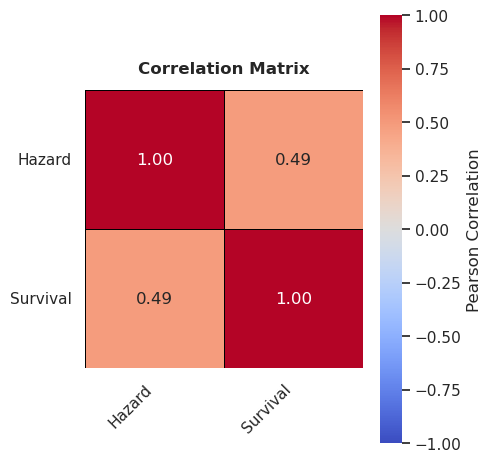

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1) Load the CSV (replace the path with your own file location)
# ------------------------------------------------------------------
df = pd.read_csv("./interpretability/interpretability_PDA_mixed50TEST/fold_0_log.csv")              # <–– adjust as needed

# ------------------------------------------------------------------
# 2) Compute the Pearson correlation for the two variables of interest
# ------------------------------------------------------------------
corr = df[["hazard_score", "survtime"]].corr()

# Optional: nicer display names on the axes
corr.index  = ["Hazard", "Survival"]
corr.columns = ["Hazard", "Survival"]

# ------------------------------------------------------------------
# 3) Plot with the exact styling of the reference figure
# ------------------------------------------------------------------
sns.set_theme(style="white")                    # clean white canvas
fig, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(
    corr,
    ax=ax,
    cmap="coolwarm",            # diverging palette (blue-white-red)
    vmin=-1, vmax=1,            # keep scale fixed at ±1
    annot=True, fmt=".2f",      # show r-values inside cells
    square=True,                # square cells like the PDF
    linewidths=0.5, linecolor="black",
    cbar_kws={"label": "Pearson Correlation"}
)

ax.set_title("Correlation Matrix", fontweight="bold", pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


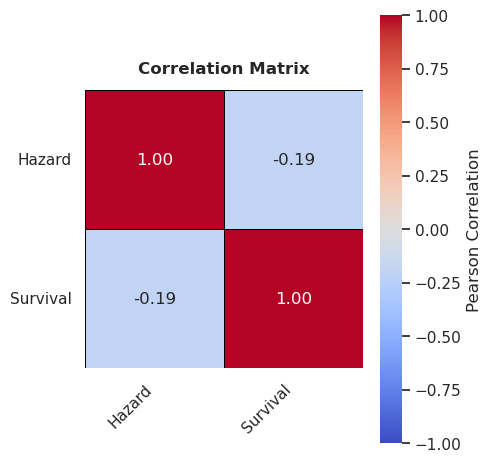

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1) Load the CSV (replace the path with your own file location)
# ------------------------------------------------------------------
df = pd.read_csv("./interpretability/interpretability_UCEC_mixed50TEST/fold_2_log.csv")              # <–– adjust as needed

# ------------------------------------------------------------------
# 2) Compute the Pearson correlation for the two variables of interest
# ------------------------------------------------------------------
corr = df[["hazard_score", "survtime"]].corr()

# Optional: nicer display names on the axes
corr.index  = ["Hazard", "Survival"]
corr.columns = ["Hazard", "Survival"]

# ------------------------------------------------------------------
# 3) Plot with the exact styling of the reference figure
# ------------------------------------------------------------------
sns.set_theme(style="white")                    # clean white canvas
fig, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(
    corr,
    ax=ax,
    cmap="coolwarm",            # diverging palette (blue-white-red)
    vmin=-1, vmax=1,            # keep scale fixed at ±1
    annot=True, fmt=".2f",      # show r-values inside cells
    square=True,                # square cells like the PDF
    linewidths=0.5, linecolor="black",
    cbar_kws={"label": "Pearson Correlation"}
)

ax.set_title("Correlation Matrix", fontweight="bold", pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Feature Visualization

## UCEC

In [52]:
# --------------------------------------------------------------
# 0) Imports
# --------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# --------------------------------------------------------------
# 1) Load the CSV and the fused features
# --------------------------------------------------------------
CSV_PATH = "./interpretability/interpretability_UCEC_mixed50TEST/fold_3_log.csv"          # <—- change if needed

df = pd.read_csv(CSV_PATH)

def load_feature(path):
    """
    Load a .npy file from `path` and collapse it to one 1-D vector.
    If the array is (n_patches, d), we average over patches.
    """
    arr = np.load(path)
    return arr.mean(axis=0) if arr.ndim > 1 else arr

X = np.vstack(df["fused_path"].apply(load_feature).to_list())
print(f"Feature matrix shape after pooling: {X.shape}")   # (n_samples, d_features)

# --------------------------------------------------------------
# 2) Create the stratification labels
# --------------------------------------------------------------
df["hazard_group"] = pd.qcut(df["hazard_score"], q=2, labels=["Low", "High"])
df["surv_group"]   = pd.qcut(df["survtime"],    q=2, labels=["Short", "Long"])

# --------------------------------------------------------------
# 3) Standardise features
# --------------------------------------------------------------
X_std = StandardScaler().fit_transform(X)

# --------------------------------------------------------------
# 4) Dimensionality reduction
# --------------------------------------------------------------
pca   = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_std)

tsne  = TSNE(n_components=2, perplexity=30, init="pca",
             learning_rate="auto", random_state=0)
X_tsne = tsne.fit_transform(X_std)

# --------------------------------------------------------------
# 5) Visualise the embeddings
# --------------------------------------------------------------
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(11, 10))
pal_hazard = {"Low": "dodgerblue", "High": "crimson"}
pal_surv   = {"Short": "goldenrod", "Long": "seagreen"}

# (row 0, col 0) PCA coloured by hazard
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=df["hazard_group"], palette=pal_hazard,
                ax=axes[0, 0], s=60, edgecolor="k")
axes[0, 0].set_title("PCA – hazard low/high")

# (row 0, col 1) PCA coloured by survival
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=df["surv_group"], palette=pal_surv,
                ax=axes[0, 1], s=60, edgecolor="k")
axes[0, 1].set_title("PCA – survival short/long")

# (row 1, col 0) t-SNE coloured by hazard
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],
                hue=df["hazard_group"], palette=pal_hazard,
                ax=axes[1, 0], s=60, edgecolor="k")
axes[1, 0].set_title("t-SNE – hazard low/high")

# (row 1, col 1) t-SNE coloured by survival
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],
                hue=df["surv_group"], palette=pal_surv,
                ax=axes[1, 1], s=60, edgecolor="k")
axes[1, 1].set_title("t-SNE – survival short/long")

# tidy up
for ax in axes.ravel():
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 6) Cluster the embeddings and compute overlap (Adjusted Rand)
# --------------------------------------------------------------
k_pca  = KMeans(n_clusters=2, random_state=0).fit(X_pca)
k_tsne = KMeans(n_clusters=2, random_state=0).fit(X_tsne)

ari_pca_hazard  = adjusted_rand_score(df["hazard_group"].cat.codes, k_pca.labels_)
ari_pca_surv    = adjusted_rand_score(df["surv_group"].cat.codes,   k_pca.labels_)
ari_tsne_hazard = adjusted_rand_score(df["hazard_group"].cat.codes, k_tsne.labels_)
ari_tsne_surv   = adjusted_rand_score(df["surv_group"].cat.codes,   k_tsne.labels_)

# --------------------------------------------------------------
# 7) Bar plot of ARI scores
# --------------------------------------------------------------
fig2, ax2 = plt.subplots(figsize=(6, 4))
labels = ["PCA vs hazard", "PCA vs survival",
          "t-SNE vs hazard", "t-SNE vs survival"]
scores = [ari_pca_hazard, ari_pca_surv, ari_tsne_hazard, ari_tsne_surv]

sns.barplot(x=labels, y=scores, ax=ax2)
ax2.set_ylabel("Adjusted Rand Index (0–1)")
ax2.set_ylim(0, 1)
ax2.set_title("Cluster / Stratification Agreement")
for idx, v in enumerate(scores):
    ax2.text(idx, v + 0.02, f"{v:.2f}", ha="center")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Feature matrix shape after pooling: (718, 256)


ValueError: Bin edges must be unique: Index([-3.069460391998291, 0.0810833647847175, 0.0810833647847175], dtype='float64', name='hazard_score').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [49]:
# ---------------------------------------------------------------
# 0) Imports
# ---------------------------------------------------------------
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401 – registers 3-D projection
import seaborn as sns

sns.set_theme(style="whitegrid")

# ---------------------------------------------------------------
# 1) Load the CSV and fused features
# ---------------------------------------------------------------
CSV_PATH =  "./interpretability/interpretability_UCEC_mixed50TEST/fold_3_log.csv"          # <—- change to your file if needed
df = pd.read_csv(CSV_PATH)

def load_fused(fpath: str) -> np.ndarray:
    """Load a .npy, collapse to one vector if it contains per-patch rows."""
    arr = np.load(Path(fpath), mmap_mode="r")
    if arr.ndim > 1:            # e.g. (n_patches, d)
        arr = arr.mean(axis=0)  # simple average pooling
    return arr

feature_list = [load_fused(p) for p in df["fused_path"]]
X = np.vstack(feature_list)     # (n_samples, d_features)

# ---------------------------------------------------------------
# 2) Generate the two binary strata
# ---------------------------------------------------------------
df["hazard_strata"]   = pd.qcut(df["hazard_score"], q=2, labels=["low", "high"])
df["survival_strata"] = pd.qcut(df["survtime"],    q=2, labels=["short", "long"])

label_palettes = {
    "hazard_strata":   {"low": "tab:blue",  "high": "tab:red"},
    "survival_strata": {"short": "tab:green", "long": "tab:orange"},
}

# ---------------------------------------------------------------
# 3) Standardise → PCA (3D) and t-SNE (3D)
# ---------------------------------------------------------------
X_std = StandardScaler().fit_transform(X)

pca   = PCA(n_components=3, random_state=0)
pca_z = pca.fit_transform(X_std)              # (n, 3)

tsne  = TSNE(n_components=3, perplexity=30,
             init="pca", learning_rate="auto",
             random_state=42)
tsne_z = tsne.fit_transform(X_std)            # (n, 3)

# ---------------------------------------------------------------
# 4) Utility – draw a 3-D scatter once
# ---------------------------------------------------------------
def scatter3d(ax, emb, labels, palette, title):
    colors = labels.map(palette)
    ax.scatter(emb[:, 0], emb[:, 1], emb[:, 2],
               c=colors, s=40, alpha=.8, edgecolor="k")
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Dim 1"); ax.set_ylabel("Dim 2"); ax.set_zlabel("Dim 3")
    # build a clean legend
    for lab, col in palette.items():
        ax.scatter([], [], [], c=col, label=lab, s=40, edgecolor="k")
    ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1.05, 1.0))

# ---------------------------------------------------------------
# 5) Produce the four 3-D plots
# ---------------------------------------------------------------
fig = plt.figure(figsize=(14, 12), constrained_layout=True)

axes = [
    fig.add_subplot(221, projection="3d"),
    fig.add_subplot(222, projection="3d"),
    fig.add_subplot(223, projection="3d"),
    fig.add_subplot(224, projection="3d"),
]

scatter3d(axes[0], pca_z, df["hazard_strata"],
          label_palettes["hazard_strata"], "PCA – Hazard strata")

scatter3d(axes[1], pca_z, df["survival_strata"],
          label_palettes["survival_strata"], "PCA – Survival strata")

scatter3d(axes[2], tsne_z, df["hazard_strata"],
          label_palettes["hazard_strata"], "t-SNE – Hazard strata")

scatter3d(axes[3], tsne_z, df["survival_strata"],
          label_palettes["survival_strata"], "t-SNE – Survival strata")

plt.show()

# ---------------------------------------------------------------
# 6) Cluster each embedding (k-means, k=2) and compute ARI
# ---------------------------------------------------------------
km_pca  = KMeans(n_clusters=2, random_state=0).fit(pca_z)
km_tsne = KMeans(n_clusters=2, random_state=0).fit(tsne_z)

ari_scores = pd.Series({
    "PCA vs hazard":   adjusted_rand_score(df["hazard_strata"],   km_pca.labels_),
    "PCA vs survival": adjusted_rand_score(df["survival_strata"], km_pca.labels_),
    "t-SNE vs hazard": adjusted_rand_score(df["hazard_strata"],   km_tsne.labels_),
    "t-SNE vs survival": adjusted_rand_score(df["survival_strata"], km_tsne.labels_),
}).sort_index()

# ---------------------------------------------------------------
# 7) Bar-chart of ARI overlaps
# ---------------------------------------------------------------
plt.figure(figsize=(8, 4))
sns.barplot(x=ari_scores.index, y=ari_scores.values, palette="viridis")
plt.ylabel("Adjusted Rand Index (0 = random, 1 = perfect)")
plt.title("Cluster ↔ Strata Agreement")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


ValueError: Bin edges must be unique: Index([-3.069460391998291, 0.0810833647847175, 0.0810833647847175], dtype='float64', name='hazard_score').
You can drop duplicate edges by setting the 'duplicates' kwarg

## PDA

Feature matrix shape after pooling: (199, 256)


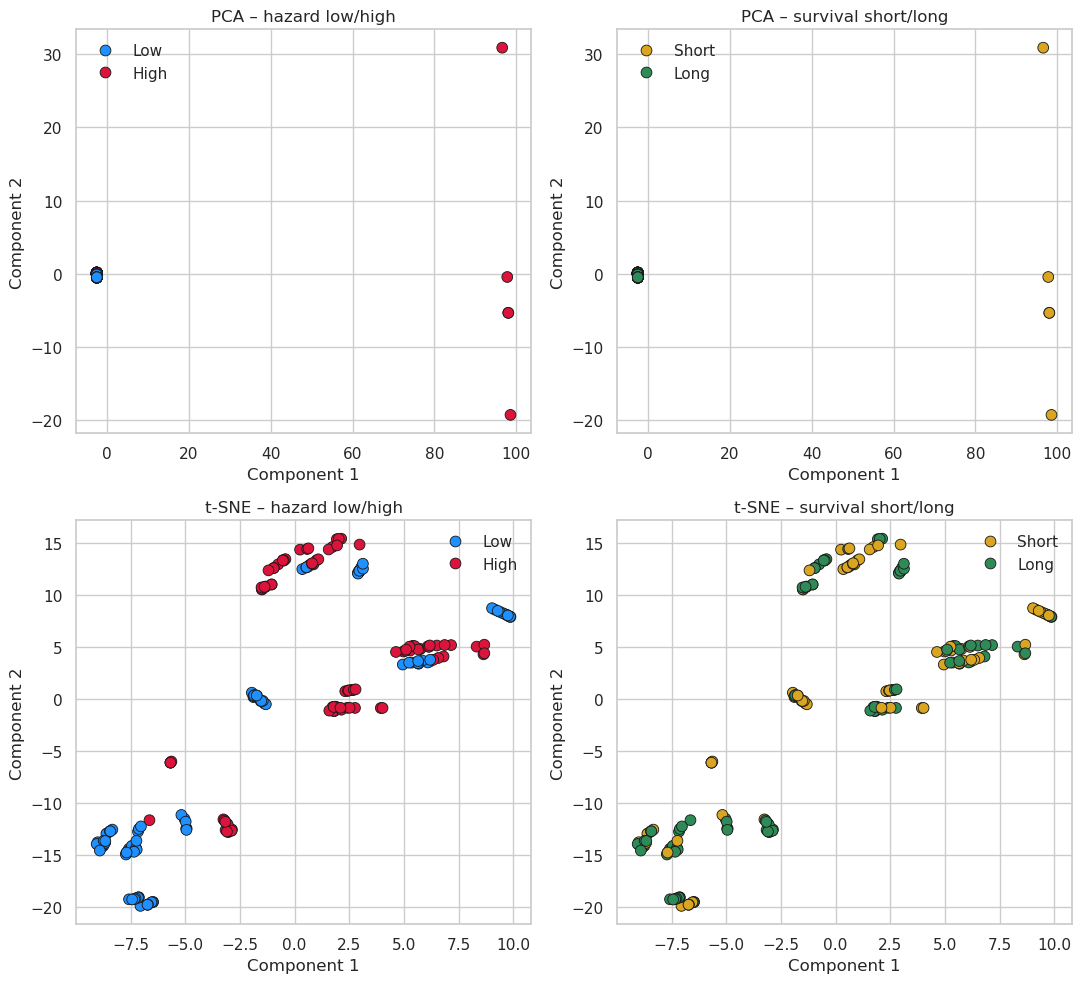

/home/users/pietro.caforio/anaconda3/envs/research_biocv_proj/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/users/pietro.caforio/anaconda3/envs/research_biocv_proj/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


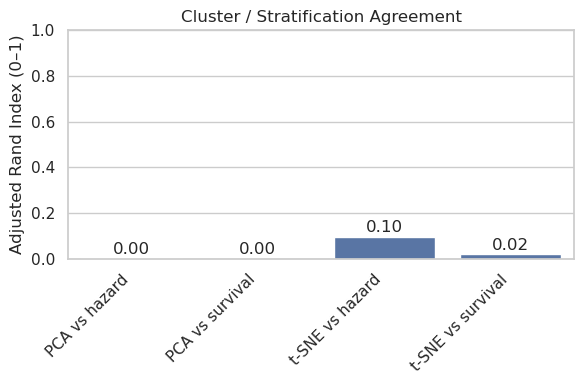

In [58]:
# --------------------------------------------------------------
# 0) Imports
# --------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# --------------------------------------------------------------
# 1) Load the CSV and the fused features
# --------------------------------------------------------------
CSV_PATH = "./interpretability/interpretability_PDA_mixed50TEST/fold_4_log.csv"          # <—- change if needed

df = pd.read_csv(CSV_PATH)

def load_feature(path):
    """
    Load a .npy file from `path` and collapse it to one 1-D vector.
    If the array is (n_patches, d), we average over patches.
    """
    arr = np.load(path)
    return arr.mean(axis=0) if arr.ndim > 1 else arr

X = np.vstack(df["fused_path"].apply(load_feature).to_list())
print(f"Feature matrix shape after pooling: {X.shape}")   # (n_samples, d_features)

# --------------------------------------------------------------
# 2) Create the stratification labels
# --------------------------------------------------------------
df["hazard_group"] = pd.qcut(df["hazard_score"], q=2, labels=["Low", "High"])
df["surv_group"]   = pd.qcut(df["survtime"],    q=2, labels=["Short", "Long"])

# --------------------------------------------------------------
# 3) Standardise features
# --------------------------------------------------------------
X_std = StandardScaler().fit_transform(X)

# --------------------------------------------------------------
# 4) Dimensionality reduction
# --------------------------------------------------------------
pca   = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_std)

tsne  = TSNE(n_components=2, perplexity=30, init="pca",
             learning_rate="auto", random_state=0)
X_tsne = tsne.fit_transform(X_std)

# --------------------------------------------------------------
# 5) Visualise the embeddings
# --------------------------------------------------------------
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(11, 10))
pal_hazard = {"Low": "dodgerblue", "High": "crimson"}
pal_surv   = {"Short": "goldenrod", "Long": "seagreen"}

# (row 0, col 0) PCA coloured by hazard
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=df["hazard_group"], palette=pal_hazard,
                ax=axes[0, 0], s=60, edgecolor="k")
axes[0, 0].set_title("PCA – hazard low/high")

# (row 0, col 1) PCA coloured by survival
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=df["surv_group"], palette=pal_surv,
                ax=axes[0, 1], s=60, edgecolor="k")
axes[0, 1].set_title("PCA – survival short/long")

# (row 1, col 0) t-SNE coloured by hazard
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],
                hue=df["hazard_group"], palette=pal_hazard,
                ax=axes[1, 0], s=60, edgecolor="k")
axes[1, 0].set_title("t-SNE – hazard low/high")

# (row 1, col 1) t-SNE coloured by survival
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],
                hue=df["surv_group"], palette=pal_surv,
                ax=axes[1, 1], s=60, edgecolor="k")
axes[1, 1].set_title("t-SNE – survival short/long")

# tidy up
for ax in axes.ravel():
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 6) Cluster the embeddings and compute overlap (Adjusted Rand)
# --------------------------------------------------------------
k_pca  = KMeans(n_clusters=2, random_state=0).fit(X_pca)
k_tsne = KMeans(n_clusters=2, random_state=0).fit(X_tsne)

ari_pca_hazard  = adjusted_rand_score(df["hazard_group"].cat.codes, k_pca.labels_)
ari_pca_surv    = adjusted_rand_score(df["surv_group"].cat.codes,   k_pca.labels_)
ari_tsne_hazard = adjusted_rand_score(df["hazard_group"].cat.codes, k_tsne.labels_)
ari_tsne_surv   = adjusted_rand_score(df["surv_group"].cat.codes,   k_tsne.labels_)

# --------------------------------------------------------------
# 7) Bar plot of ARI scores
# --------------------------------------------------------------
fig2, ax2 = plt.subplots(figsize=(6, 4))
labels = ["PCA vs hazard", "PCA vs survival",
          "t-SNE vs hazard", "t-SNE vs survival"]
scores = [ari_pca_hazard, ari_pca_surv, ari_tsne_hazard, ari_tsne_surv]

sns.barplot(x=labels, y=scores, ax=ax2)
ax2.set_ylabel("Adjusted Rand Index (0–1)")
ax2.set_ylim(0, 1)
ax2.set_title("Cluster / Stratification Agreement")
for idx, v in enumerate(scores):
    ax2.text(idx, v + 0.02, f"{v:.2f}", ha="center")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


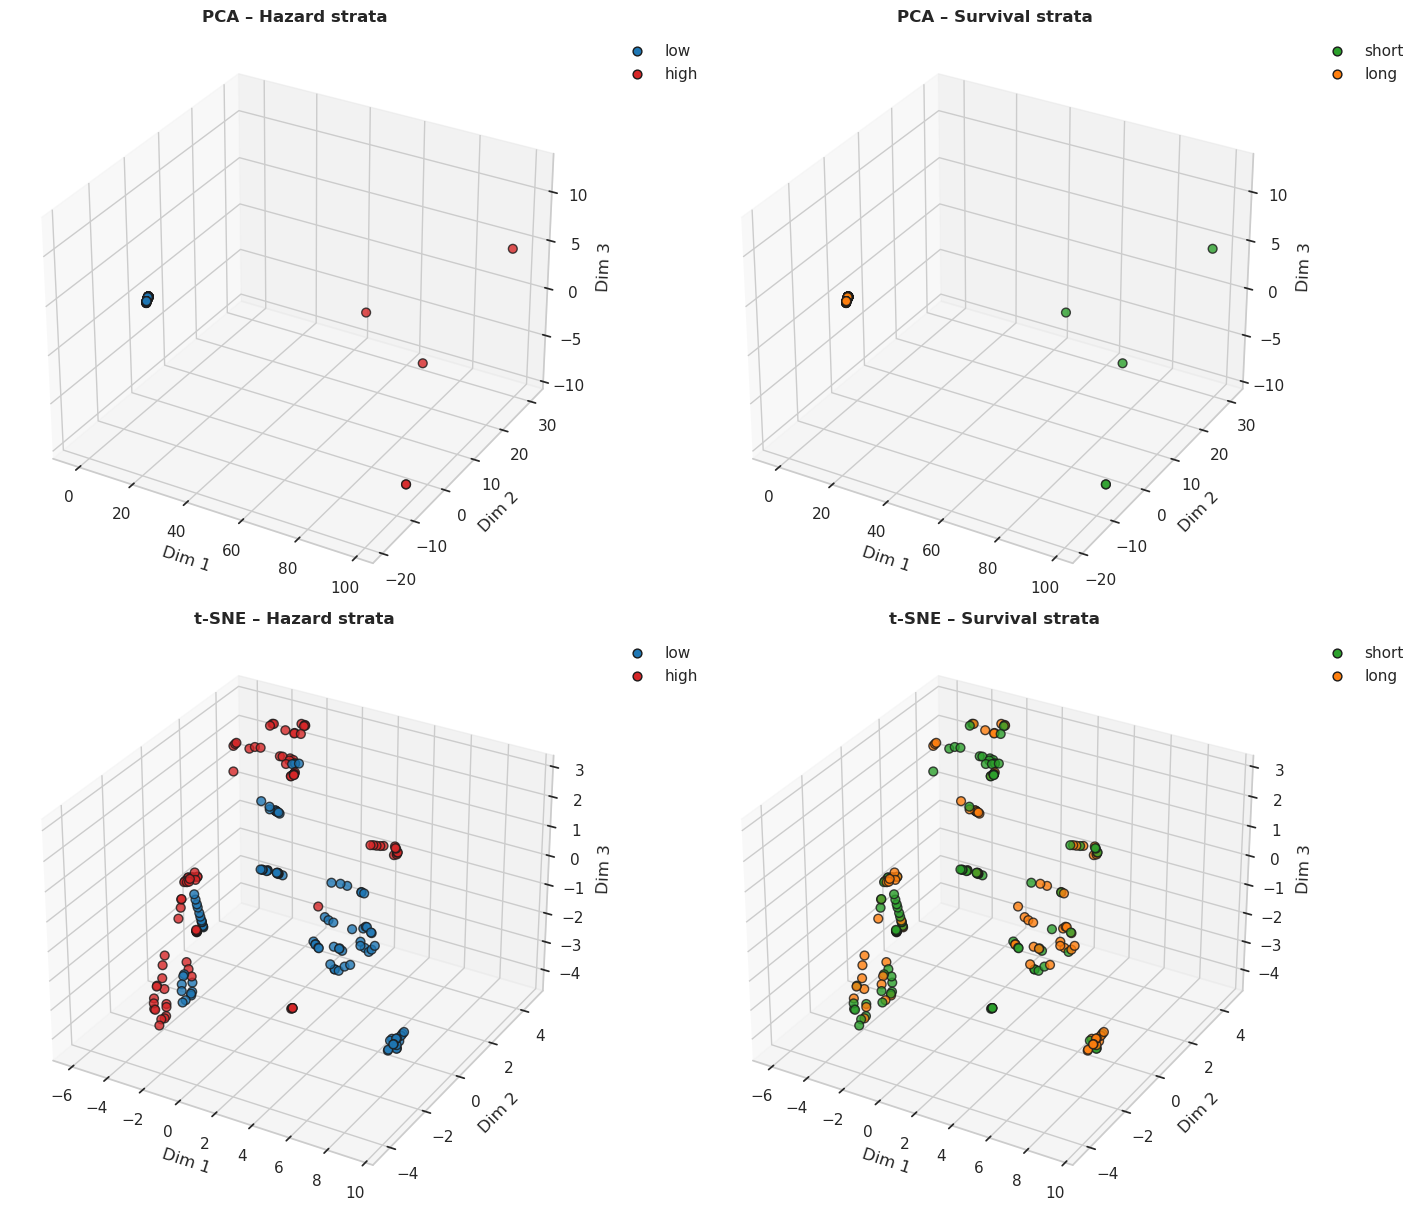

/home/users/pietro.caforio/anaconda3/envs/research_biocv_proj/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/users/pietro.caforio/anaconda3/envs/research_biocv_proj/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_3807108/235122733.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ari_scores.index, y=ari_scores.values, palette="viridis")


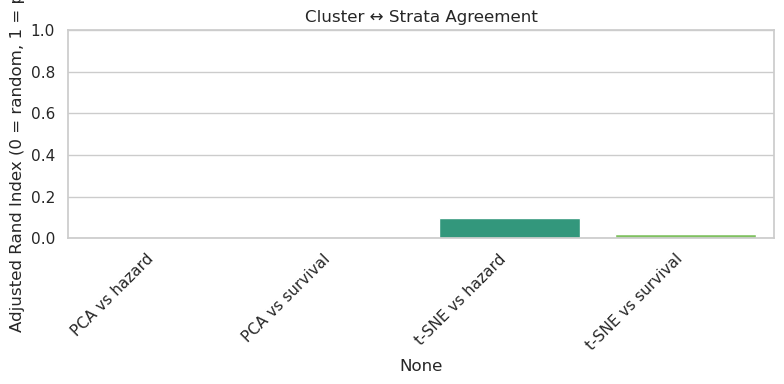

In [63]:
# ---------------------------------------------------------------
# 0) Imports
# ---------------------------------------------------------------
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401 – registers 3-D projection
import seaborn as sns

sns.set_theme(style="whitegrid")

# ---------------------------------------------------------------
# 1) Load the CSV and fused features
# ---------------------------------------------------------------
CSV_PATH =  "./interpretability/interpretability_PDA_mixed50TEST/fold_4_log.csv"          # <—- change to your file if needed
df = pd.read_csv(CSV_PATH)

def load_fused(fpath: str) -> np.ndarray:
    """Load a .npy, collapse to one vector if it contains per-patch rows."""
    arr = np.load(Path(fpath), mmap_mode="r")
    if arr.ndim > 1:            # e.g. (n_patches, d)
        arr = arr.mean(axis=0)  # simple average pooling
    return arr

feature_list = [load_fused(p) for p in df["fused_path"]]
X = np.vstack(feature_list)     # (n_samples, d_features)

# ---------------------------------------------------------------
# 2) Generate the two binary strata
# ---------------------------------------------------------------
df["hazard_strata"]   = pd.qcut(df["hazard_score"], q=2, labels=["low", "high"])
df["survival_strata"] = pd.qcut(df["survtime"],    q=2, labels=["short", "long"])

label_palettes = {
    "hazard_strata":   {"low": "tab:blue",  "high": "tab:red"},
    "survival_strata": {"short": "tab:green", "long": "tab:orange"},
}

# ---------------------------------------------------------------
# 3) Standardise → PCA (3D) and t-SNE (3D)
# ---------------------------------------------------------------
X_std = StandardScaler().fit_transform(X)

pca   = PCA(n_components=3, random_state=0)
pca_z = pca.fit_transform(X_std)              # (n, 3)

tsne  = TSNE(n_components=3, perplexity=30,
             init="pca", learning_rate="auto",
             random_state=42)
tsne_z = tsne.fit_transform(X_std)            # (n, 3)

# ---------------------------------------------------------------
# 4) Utility – draw a 3-D scatter once
# ---------------------------------------------------------------
def scatter3d(ax, emb, labels, palette, title):
    colors = labels.map(palette)
    ax.scatter(emb[:, 0], emb[:, 1], emb[:, 2],
               c=colors, s=40, alpha=.8, edgecolor="k")
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Dim 1"); ax.set_ylabel("Dim 2"); ax.set_zlabel("Dim 3")
    # build a clean legend
    for lab, col in palette.items():
        ax.scatter([], [], [], c=col, label=lab, s=40, edgecolor="k")
    ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1.05, 1.0))

# ---------------------------------------------------------------
# 5) Produce the four 3-D plots
# ---------------------------------------------------------------
fig = plt.figure(figsize=(14, 12), constrained_layout=True)

axes = [
    fig.add_subplot(221, projection="3d"),
    fig.add_subplot(222, projection="3d"),
    fig.add_subplot(223, projection="3d"),
    fig.add_subplot(224, projection="3d"),
]

scatter3d(axes[0], pca_z, df["hazard_strata"],
          label_palettes["hazard_strata"], "PCA – Hazard strata")

scatter3d(axes[1], pca_z, df["survival_strata"],
          label_palettes["survival_strata"], "PCA – Survival strata")

scatter3d(axes[2], tsne_z, df["hazard_strata"],
          label_palettes["hazard_strata"], "t-SNE – Hazard strata")

scatter3d(axes[3], tsne_z, df["survival_strata"],
          label_palettes["survival_strata"], "t-SNE – Survival strata")

plt.show()

# ---------------------------------------------------------------
# 6) Cluster each embedding (k-means, k=2) and compute ARI
# ---------------------------------------------------------------
km_pca  = KMeans(n_clusters=2, random_state=0).fit(pca_z)
km_tsne = KMeans(n_clusters=2, random_state=0).fit(tsne_z)

ari_scores = pd.Series({
    "PCA vs hazard":   adjusted_rand_score(df["hazard_strata"],   km_pca.labels_),
    "PCA vs survival": adjusted_rand_score(df["survival_strata"], km_pca.labels_),
    "t-SNE vs hazard": adjusted_rand_score(df["hazard_strata"],   km_tsne.labels_),
    "t-SNE vs survival": adjusted_rand_score(df["survival_strata"], km_tsne.labels_),
}).sort_index()

# ---------------------------------------------------------------
# 7) Bar-chart of ARI overlaps
# ---------------------------------------------------------------
plt.figure(figsize=(8, 4))
sns.barplot(x=ari_scores.index, y=ari_scores.values, palette="viridis")
plt.ylabel("Adjusted Rand Index (0 = random, 1 = perfect)")
plt.title("Cluster ↔ Strata Agreement")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
